#### Librerias


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator
import seaborn as sns

import statsmodels.api as sm

import yfinance as yf

from pypfopt import EfficientFrontier, expected_returns
from pypfopt import risk_models
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.risk_models import CovarianceShrinkage

import quantstats as qs

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Funciones


###### Originales

In [3]:
"""
# Función para calcular el portafolio con máximo Sharpe (devuelve valores ponderados)
def calculate_max_sharpe(prices, risk_free=0.05, save_weights=False):
    prices = prices.dropna()    
    mu = expected_returns.mean_historical_return(prices)
    S = risk_models.sample_cov(prices)
    ef = EfficientFrontier(mu, S)
    ef.max_sharpe(risk_free_rate=risk_free)
    weights = ef.clean_weights()
    if save_weights:
        return weights
    # Multiplica precios históricos por los pesos para obtener valores ponderados
    return prices.mul(weights, axis=1).sum(axis=1)

# Función para calcular el portafolio de mínima volatilidad
def calculate_min_volatility(prices, save_weights=False):
    prices = prices.dropna()    
    mu = expected_returns.mean_historical_return(prices)
    S = risk_models.sample_cov(prices)
    ef = EfficientFrontier(mu, S)
    ef.min_volatility()
    weights = ef.clean_weights()
    if save_weights:
        return weights
    # Multiplica precios históricos por los pesos para obtener valores ponderados
    return prices.mul(weights, axis=1).sum(axis=1)


# Función para calcular el portafolio de máximo rendimiento esperado
def calculate_max_return(prices, save_weights=False):
    prices = prices.dropna()    
    mu = expected_returns.mean_historical_return(prices)
    S = risk_models.sample_cov(prices)
    ef = EfficientFrontier(mu, S)
    ef.max_quadratic_utility()
    weights = ef.clean_weights()
    if save_weights:
        return weights
    # Multiplica precios históricos por los pesos para obtener valores ponderados
    return prices.mul(weights, axis=1).sum(axis=1)

# Funcion para calcular un portafolio de pesos iguales con pyportfolioopt
def calculate_equal_weights(prices, save_weights=False):
    prices = prices.dropna()
    num_assets = len(prices.columns)
    # Calcular pesos iguales
    weight = 1.0 / num_assets
    weights = {asset: weight for asset in prices.columns}
    if save_weights:
        return weights
    return prices.mul(weights, axis=1).sum(axis=1)


# Funcion para calculrar portafolio con un riesgo fijo usando pyportfolioopt
def calculate_risk_limit(prices, risk_limit=0.02, save_weights=False):
    prices = prices.dropna()    
    mu = expected_returns.mean_historical_return(prices)
    S = risk_models.sample_cov(prices)
    ef = EfficientFrontier(mu, S)
    ef.efficient_risk(risk_limit)
    weights = ef.clean_weights()
    if save_weights:
        return weights
    # Multiplica precios históricos por los pesos para obtener valores ponderados
    return prices.mul(weights, axis=1).sum(axis=1)
"""

'\n# Función para calcular el portafolio con máximo Sharpe (devuelve valores ponderados)\ndef calculate_max_sharpe(prices, risk_free=0.05, save_weights=False):\n    prices = prices.dropna()    \n    mu = expected_returns.mean_historical_return(prices)\n    S = risk_models.sample_cov(prices)\n    ef = EfficientFrontier(mu, S)\n    ef.max_sharpe(risk_free_rate=risk_free)\n    weights = ef.clean_weights()\n    if save_weights:\n        return weights\n    # Multiplica precios históricos por los pesos para obtener valores ponderados\n    return prices.mul(weights, axis=1).sum(axis=1)\n\n# Función para calcular el portafolio de mínima volatilidad\ndef calculate_min_volatility(prices, save_weights=False):\n    prices = prices.dropna()    \n    mu = expected_returns.mean_historical_return(prices)\n    S = risk_models.sample_cov(prices)\n    ef = EfficientFrontier(mu, S)\n    ef.min_volatility()\n    weights = ef.clean_weights()\n    if save_weights:\n        return weights\n    # Multiplica p

In [4]:
"""
def calculate_max_sharpe(prices, risk_free=0.05, save_weights=False, index_calcs=False):
    prices = prices.dropna()
    mu = expected_returns.mean_historical_return(prices)
    S = risk_models.sample_cov(prices)
    ef = EfficientFrontier(mu, S)
    ef.max_sharpe(risk_free_rate=risk_free)
    weights = ef.clean_weights()
    returns = prices.pct_change().dropna()
    portfolio_returns = returns.dot(pd.Series(weights))
    if index_calcs:
        metrics = calculate_metrics(portfolio_returns, prices.index, risk_free)
        return metrics
    
    if save_weights:
        return weights

    return portfolio_returns

def calculate_min_volatility(prices, risk_free=0.05, save_weights=False, index_calcs=False):
    prices = prices.dropna()
    mu = expected_returns.mean_historical_return(prices)
    S = risk_models.sample_cov(prices)
    ef = EfficientFrontier(mu, S)
    ef.min_volatility()
    weights = ef.clean_weights()
    returns = prices.pct_change().dropna()
    portfolio_returns = returns.dot(pd.Series(weights))
    if index_calcs:
        metrics = calculate_metrics(portfolio_returns, prices.index, risk_free)
        return metrics
    
    if save_weights:
        return weights

    return portfolio_returns

def calculate_max_return(prices, risk_free=0.05, save_weights=False, index_calcs=False):
    prices = prices.dropna()
    mu = expected_returns.mean_historical_return(prices)
    S = risk_models.sample_cov(prices)
    ef = EfficientFrontier(mu, S)
    ef.max_quadratic_utility()
    weights = ef.clean_weights()
    returns = prices.pct_change().dropna()
    portfolio_returns = returns.dot(pd.Series(weights))
    if index_calcs:
        metrics = calculate_metrics(portfolio_returns, prices.index, risk_free)
        return metrics
    
    if save_weights:
        return weights

    return portfolio_returns

def calculate_equal_weights(prices, risk_free=0.05, save_weights=False, index_calcs=False):
    prices = prices.dropna()
    num_assets = len(prices.columns)
    weights = {asset: 1.0 / num_assets for asset in prices.columns}
    returns = prices.pct_change().dropna()
    portfolio_returns = returns.dot(pd.Series(weights))
    if index_calcs:
        metrics = calculate_metrics(portfolio_returns, prices.index, risk_free)
        return metrics
    
    if save_weights:
        return weights

    return portfolio_returns

def calculate_risk_limit(prices, risk_free=0.05, risk_limit=0.20, save_weights=False, index_calcs=False):
    prices = prices.dropna()
    mu = expected_returns.mean_historical_return(prices)
    S = risk_models.sample_cov(prices)
    ef = EfficientFrontier(mu, S)
    ef.efficient_risk(risk_limit)
    weights = ef.clean_weights()
    returns = prices.pct_change().dropna()
    portfolio_returns = returns.dot(pd.Series(weights))
    if index_calcs:
        metrics = calculate_metrics(portfolio_returns, prices.index, risk_free)
        return metrics
    if save_weights:
        return weights

    return portfolio_returns
"""

"""
# Función para calcular y obtener métricas de portafolios específicos
def calcular_portafolios_especificos(returns, risk_free=0.05, risk_limit=0.20):
    mu = expected_returns.mean_historical_return(returns)
    S = risk_models.sample_cov(returns)
    ef = EfficientFrontier(mu, S)

    # Portafolio de máximo Sharpe
    ef.max_sharpe(risk_free_rate=risk_free)
    weights_sharpe = ef.clean_weights()
    performance_sharpe = ef.portfolio_performance(risk_free_rate=risk_free)

    # Portafolio de mínima volatilidad
    ef_min_vol = EfficientFrontier(mu, S)
    ef_min_vol.min_volatility()
    weights_min_vol = ef_min_vol.clean_weights()
    performance_min_vol = ef_min_vol.portfolio_performance()

    # Portafolio de pesos iguales
    n_assets = len(mu)
    weights_equal = np.array([1/n_assets] * n_assets)
    ret_equal = np.dot(weights_equal, mu)
    vol_equal = np.sqrt(np.dot(weights_equal.T, np.dot(S, weights_equal)))
    sharpe_equal = (ret_equal - risk_free) / vol_equal
    performance_equal = (ret_equal, vol_equal, sharpe_equal)
    
    # Portafolio de máxima utilidad cuadrática
    ef_max_utility = EfficientFrontier(mu, S)
    ef_max_utility.max_quadratic_utility()
    weights_max_utility = ef_max_utility.clean_weights()
    performance_max_utility = ef_max_utility.portfolio_performance()

    # Portafolio de riesgo fijo
    ef_risk_limit = EfficientFrontier(mu, S)
    ef_risk_limit.efficient_risk(risk_limit)
    weights_risk_limit = ef_risk_limit.clean_weights()
    performance_risk_limit = ef_risk_limit.portfolio_performance()
    
    # Métricas de los activos individuales
    performance_activos = []
    for i, asset in enumerate(returns.columns):
        weights_asset = np.zeros(n_assets)
        weights_asset[i] = 1
        ret_asset = np.dot(weights_asset, mu)
        vol_asset = np.sqrt(np.dot(weights_asset.T, np.dot(S, weights_asset)))
        sharpe_asset = (ret_asset - risk_free) / vol_asset
        performance_activos.append((asset, ret_asset, vol_asset, sharpe_asset))

    return {
        "sharpe": {"weights": weights_sharpe, "performance": performance_sharpe},
        "min_vol": {"weights": weights_min_vol, "performance": performance_min_vol},
        "equal": {"weights": weights_equal, "performance": performance_equal},
        "max_utility": {"weights": weights_max_utility, "performance": performance_max_utility},
        "risk_limit": {"weights": weights_risk_limit, "performance": performance_risk_limit},
        "activos": performance_activos
    }

    # Función para calcular las métricas de los portafolios generados aleatoriamente
def calcular_metricas_aleatorias(portfolios, mu, S, risk_free=0.05):
    expected_returns_all = portfolios.dot(mu)
    portfolio_volatility = np.sqrt(np.diag(portfolios.dot(S).dot(portfolios.T)))
    sharpe_ratios = (expected_returns_all - risk_free) / portfolio_volatility
    return expected_returns_all, portfolio_volatility, sharpe_ratios
"""

'\n# Función para calcular y obtener métricas de portafolios específicos\ndef calcular_portafolios_especificos(returns, risk_free=0.05, risk_limit=0.20):\n    mu = expected_returns.mean_historical_return(returns)\n    S = risk_models.sample_cov(returns)\n    ef = EfficientFrontier(mu, S)\n\n    # Portafolio de máximo Sharpe\n    ef.max_sharpe(risk_free_rate=risk_free)\n    weights_sharpe = ef.clean_weights()\n    performance_sharpe = ef.portfolio_performance(risk_free_rate=risk_free)\n\n    # Portafolio de mínima volatilidad\n    ef_min_vol = EfficientFrontier(mu, S)\n    ef_min_vol.min_volatility()\n    weights_min_vol = ef_min_vol.clean_weights()\n    performance_min_vol = ef_min_vol.portfolio_performance()\n\n    # Portafolio de pesos iguales\n    n_assets = len(mu)\n    weights_equal = np.array([1/n_assets] * n_assets)\n    ret_equal = np.dot(weights_equal, mu)\n    vol_equal = np.sqrt(np.dot(weights_equal.T, np.dot(S, weights_equal)))\n    sharpe_equal = (ret_equal - risk_free) / 

###### Portafolios y metricas

In [5]:
def calculate_max_sharpe(data, risk_free=0.05, min_weight=0, save_weights=False, index_calcs=False):
    data = data.dropna()
    
    mu = expected_returns.mean_historical_return(data, returns_data=True)
    S = risk_models.sample_cov(data, returns_data=True)
    ef = EfficientFrontier(mu, S)
    if min_weight > 0:
        ef.add_constraint(lambda w: w >= min_weight)
    
    ef.max_sharpe(risk_free_rate=risk_free)
    weights = ef.clean_weights()
    
    returns = data
    portfolio_returns = returns.dot(pd.Series(weights))
    
    if index_calcs:
        metrics = calculate_metrics(portfolio_returns, returns.index, risk_free)
        return metrics
    
    if save_weights:
        return weights

    return portfolio_returns

def calculate_min_volatility(returns, risk_free=0.05, min_weight=0, save_weights=False, index_calcs=False):
    returns = returns.dropna()

    mu = expected_returns.mean_historical_return(returns, returns_data=True)
    S = risk_models.sample_cov(returns, returns_data=True)
    ef = EfficientFrontier(mu, S)
    
    if min_weight > 0:
        ef.add_constraint(lambda w: w >= min_weight)

    ef.min_volatility()
    weights = ef.clean_weights()
    portfolio_returns = returns.dot(pd.Series(weights))
    
    if index_calcs:
        metrics = calculate_metrics(portfolio_returns, returns.index, risk_free)
        return metrics
    
    if save_weights:
        return weights

    return portfolio_returns

def calculate_max_return(returns, risk_free=0.05, min_weight=0, save_weights=False, index_calcs=False):
    returns = returns.dropna()
    
    mu = expected_returns.mean_historical_return(returns, returns_data=True)
    S = risk_models.sample_cov(returns, returns_data=True)
    ef = EfficientFrontier(mu, S)
    if min_weight > 0:
        ef.add_constraint(lambda w: w >= min_weight)
    
    ef.max_quadratic_utility()
    weights = ef.clean_weights()
    portfolio_returns = returns.dot(pd.Series(weights))
    
    if index_calcs:
        metrics = calculate_metrics(portfolio_returns, returns.index, risk_free)
        return metrics
    
    if save_weights:
        return weights

    return portfolio_returns

def calculate_equal_weights(returns, risk_free=0.05, save_weights=False, index_calcs=False):
    returns = returns.dropna()
    num_assets = len(returns.columns)
    weights = {asset: 1.0 / num_assets for asset in returns.columns}
    
    portfolio_returns = returns.dot(pd.Series(weights))
    if index_calcs:
        metrics = calculate_metrics(portfolio_returns, returns.index, risk_free)
        return metrics
    
    if save_weights:
        return weights

    return portfolio_returns

def calculate_risk_limit(returns, risk_free=0.05, risk_limit=0.20, min_weight=0, save_weights=False, index_calcs=False):
    returns = returns.dropna()
    
    mu = expected_returns.mean_historical_return(returns, returns_data=True)
    S = risk_models.sample_cov(returns, returns_data=True)
    ef = EfficientFrontier(mu, S)
    if min_weight > 0:
        ef.add_constraint(lambda w: w >= min_weight)
    
    ef.efficient_risk(risk_limit)
    weights = ef.clean_weights()

    portfolio_returns = returns.dot(pd.Series(weights))
    
    if index_calcs:
        metrics = calculate_metrics(portfolio_returns, returns.index, risk_free)
        return metrics
    
    if save_weights:
        return weights

    return portfolio_returns


In [6]:
"""
# Función para calcular todos los indicadores
def calculate_metrics(returns, date_index, risk_free):
    cumulative_return = (returns + 1).cumprod() - 1
    cumulative_return = cumulative_return.iloc[-1]
    cagr = calculate_cagr(returns)
    volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = (returns.mean() * 252 - risk_free) / volatility
    sortino_ratio = calculate_sortino(returns, risk_free)
    omega_ratio = calculate_omega(returns, risk_free)
    max_drawdown = calculate_max_drawdown(returns)
    max_drawdown_duration = calculate_drawdown_duration(returns)

    return {
        "start_period": date_index[0].strftime("%Y-%m-%d"),
        "end_period": date_index[-1].strftime("%Y-%m-%d"),
        "risk_free_rate %": risk_free * 100,
        "expected_return %": (returns.mean() * 252)*100,
        "volatility %": volatility*100,
        "cumulative_return %": cumulative_return*100,
        "cagr %": cagr*100,
        "sharpe_ratio": sharpe_ratio,
        "sortino_ratio": sortino_ratio,
        "omega_ratio": omega_ratio,
        "max_drawdown": max_drawdown*100,
        "max_drawdown_duration": max_drawdown_duration
    }

def calculate_cagr(returns):
    n_periods = len(returns) / 252
    cumulative_return = (returns + 1).cumprod() - 1
    cumulative_return = cumulative_return.iloc[-1]
    return ((1 + cumulative_return) ** (1 / n_periods) - 1)

def calculate_sortino(returns, risk_free):
    downside_returns = returns[returns < risk_free / 252]
    expected_return = returns.mean() * 252
    downside_deviation = np.std(downside_returns) * np.sqrt(252)
    return (expected_return - risk_free) / downside_deviation

def calculate_omega(returns, risk_free):
    threshold_return = risk_free / 252
    gain = returns[returns > threshold_return].sum()
    loss = -returns[returns <= threshold_return].sum()
    return gain / loss if loss != 0 else np.inf

def calculate_max_drawdown(returns):
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

def calculate_drawdown_duration(returns):
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    in_drawdown = drawdown != 0
    drawdown_duration = in_drawdown.groupby((in_drawdown != in_drawdown.shift()).cumsum()).cumsum()
    return drawdown_duration.max()

# Función para calcular las métricas para todos los portafolios y activos
def calculate_indicators_for_all_portfolios(returns, risk_free=0.05, risk_limit=0.2, min_weight=0,include_assets=False):
    portafolios = {
        "Max_Sharpe": calculate_max_sharpe(returns, risk_free=risk_free, min_weight=min_weight, index_calcs=True),
        
        "Min_Volatility": calculate_min_volatility(returns, risk_free=risk_free, min_weight=min_weight, index_calcs=True),
        
        "Max_Return": calculate_max_return(returns, risk_free=risk_free, min_weight=min_weight, index_calcs=True),
        
        "Equal_Weight": calculate_equal_weights(returns, risk_free=risk_free, index_calcs=True),
        
        "Risk_Limit": calculate_risk_limit(returns, risk_limit=risk_limit,risk_free=risk_free, min_weight=min_weight, index_calcs=True)
    }
    
    if include_assets:
        asset_indicators = {}
        for asset in returns.columns:
            asset_returns = returns[asset].pct_change().dropna()
            asset_indicators[asset] = calculate_metrics(asset_returns, returns.index, risk_free)
        portafolios.update(asset_indicators)

    df_indicators = pd.DataFrame(portafolios)
    return df_indicators
    
"""

'\n# Función para calcular todos los indicadores\ndef calculate_metrics(returns, date_index, risk_free):\n    cumulative_return = (returns + 1).cumprod() - 1\n    cumulative_return = cumulative_return.iloc[-1]\n    cagr = calculate_cagr(returns)\n    volatility = returns.std() * np.sqrt(252)\n    sharpe_ratio = (returns.mean() * 252 - risk_free) / volatility\n    sortino_ratio = calculate_sortino(returns, risk_free)\n    omega_ratio = calculate_omega(returns, risk_free)\n    max_drawdown = calculate_max_drawdown(returns)\n    max_drawdown_duration = calculate_drawdown_duration(returns)\n\n    return {\n        "start_period": date_index[0].strftime("%Y-%m-%d"),\n        "end_period": date_index[-1].strftime("%Y-%m-%d"),\n        "risk_free_rate %": risk_free * 100,\n        "expected_return %": (returns.mean() * 252)*100,\n        "volatility %": volatility*100,\n        "cumulative_return %": cumulative_return*100,\n        "cagr %": cagr*100,\n        "sharpe_ratio": sharpe_ratio,\n 

###### Portfolio generation

In [7]:

# Función para agregar activos y portafolios a un solo DataFrame
def generate_portfolio_df(data, include_sharpe=True, include_min_vol=True, include_max_return=True, include_equal_weight=True, include_risk_limit=True, risk_free=0.05, risk_limit=0.02, min_weight=0, include_assets=False, save_weights=False):
    # Crear una copia del DataFrame original
    portfolio_df = data.copy()

    # Calcular y añadir las estrategias seleccionadas al DataFrame
    if include_sharpe:
        portfolio_df['Max_Sharpe'] = calculate_max_sharpe(data, risk_free=risk_free, min_weight=min_weight, save_weights=save_weights)
        
    if include_min_vol:
        portfolio_df['Min_Volatility'] = calculate_min_volatility(data, min_weight=min_weight, save_weights=save_weights)
        
    if include_max_return:
        portfolio_df['Max_Return'] = calculate_max_return(data, min_weight=min_weight, save_weights=save_weights)
        
    if include_equal_weight:
        portfolio_df['Equal_Weight'] = calculate_equal_weights(data, save_weights=save_weights)
        
    if include_risk_limit:
        #portfolio_df['Risk_Limit'] = calculate_risk_limit(data, risk_limit=risk_limit, save_weights=save_weights)
        portfolio_df['Risk_Limit'] = calculate_risk_limit(data, risk_limit=risk_limit, min_weight=min_weight, save_weights=save_weights)
# para hacer que solo regrese los portafolios y no los activos se usa el siguiente codigo
#     # Eliminar las columnas de activos
    if not include_assets:
        portfolio_df = portfolio_df.drop(data.columns, axis=1)
    return portfolio_df

###### Add cripto to portafolio

In [8]:
# Funcion para agregar criptos a portafolios tradicionales
def add_cripto(tradicionales, cripto, cry_list):
    # Asegurarse de que ambos DataFrames tengan índices de tipo datetime
    tradicionales.index = pd.to_datetime(tradicionales.index)
    cripto.index = pd.to_datetime(cripto.index)
    
    # añadir un try para evitar errores
    try:
        # Verificar que las criptomonedas seleccionadas existan en el DataFrame
        cry_list = [crypto for crypto in cry_list if crypto in cripto.columns]
    except:
        print('Error: cripto no es un DataFrame')
    # Verificar que las criptomonedas seleccionadas existan en el DataFrame
    
    # Seleccionar solo las criptomonedas de la lista
    criptos_seleccionadas = cripto[cry_list]
    
    # Combinar los DataFrames, alineando por fecha
    combinado = pd.merge(tradicionales, criptos_seleccionadas, left_index=True, right_index=True, how='inner').dropna()
    
    return combinado

###### Frontera Eficiente

In [9]:
# Función para calcular y obtener métricas de portafolios específicos
def calcular_portafolios_especificos2(returns, risk_free=0.05, risk_limit=0.20, min_weight=0):
    mu = expected_returns.mean_historical_return(returns )
    S = risk_models.sample_cov(returns)

    # Portafolio de máximo Sharpe
    ef = EfficientFrontier(mu, S)
    if min_weight > 0:
        ef.add_constraint(lambda w: w >= min_weight)
    ef.max_sharpe(risk_free_rate=risk_free)
    weights_sharpe = ef.clean_weights()
    performance_sharpe = ef.portfolio_performance(risk_free_rate=risk_free)

    # Portafolio de mínima volatilidad
    ef_min_vol = EfficientFrontier(mu, S)
    if min_weight > 0:
        ef_min_vol.add_constraint(lambda w: w >= min_weight)
    ef_min_vol.min_volatility()
    weights_min_vol = ef_min_vol.clean_weights()
    performance_min_vol = ef_min_vol.portfolio_performance()

    # Portafolio de pesos iguales
    n_assets = len(mu)
    weights_equal = np.array([max(min_weight, 1/n_assets)] * n_assets)
    if sum(weights_equal) < 1:
        weights_equal *= 1 / sum(weights_equal)
    ret_equal = np.dot(weights_equal, mu)
    vol_equal = np.sqrt(np.dot(weights_equal.T, np.dot(S, weights_equal)))
    sharpe_equal = (ret_equal - risk_free) / vol_equal
    performance_equal = (ret_equal, vol_equal, sharpe_equal)
    
    # Portafolio de máxima utilidad cuadrática
    ef_max_utility = EfficientFrontier(mu, S)
    if min_weight > 0:
        ef_max_utility.add_constraint(lambda w: w >= min_weight)
    ef_max_utility.max_quadratic_utility()
    weights_max_utility = ef_max_utility.clean_weights()
    performance_max_utility = ef_max_utility.portfolio_performance()

    # Portafolio de riesgo fijo
    ef_risk_limit = EfficientFrontier(mu, S)
    if min_weight > 0:
        ef_risk_limit.add_constraint(lambda w: w >= min_weight)
    ef_risk_limit.efficient_risk(risk_limit)
    weights_risk_limit = ef_risk_limit.clean_weights()
    performance_risk_limit = ef_risk_limit.portfolio_performance()
    
    # Métricas de los activos individuales
    performance_activos = []
    for i, asset in enumerate(returns.columns):
        weights_asset = np.zeros(n_assets)
        weights_asset[i] = 1
        ret_asset = np.dot(weights_asset, mu)
        vol_asset = np.sqrt(np.dot(weights_asset.T, np.dot(S, weights_asset)))
        sharpe_asset = (ret_asset - risk_free) / vol_asset
        performance_activos.append((asset, ret_asset, vol_asset, sharpe_asset))

    return {
        "sharpe": {"weights": weights_sharpe, "performance": performance_sharpe},
        "min_vol": {"weights": weights_min_vol, "performance": performance_min_vol},
        "equal": {"weights": weights_equal, "performance": performance_equal},
        "max_utility": {"weights": weights_max_utility, "performance": performance_max_utility},
        "risk_limit": {"weights": weights_risk_limit, "performance": performance_risk_limit},
        "activos": performance_activos
    }


In [10]:
def calcular_portafolios_especificos(returns, risk_free=0.05, risk_limit=0.20, min_weight=0):
    # Nota: 'returns' ahora son rendimientos porcentuales, no precios

    # No necesitamos calcular los rendimientos, ya los tenemos
    mu = expected_returns.mean_historical_return(returns, returns_data=True)
    S = risk_models.sample_cov(returns, returns_data=True)

    # Portafolio de máximo Sharpe
    ef = EfficientFrontier(mu, S)
    if min_weight > 0:
        ef.add_constraint(lambda w: w >= min_weight)
    ef.max_sharpe(risk_free_rate=risk_free)
    weights_sharpe = ef.clean_weights()
    performance_sharpe = ef.portfolio_performance(risk_free_rate=risk_free)

    # Portafolio de mínima volatilidad
    ef_min_vol = EfficientFrontier(mu, S)
    if min_weight > 0:
        ef_min_vol.add_constraint(lambda w: w >= min_weight)
    ef_min_vol.min_volatility()
    weights_min_vol = ef_min_vol.clean_weights()
    performance_min_vol = ef_min_vol.portfolio_performance()

    # Portafolio de pesos iguales
    n_assets = len(mu)
    weights_equal = np.array([max(min_weight, 1/n_assets)] * n_assets)
    if sum(weights_equal) < 1:
        weights_equal *= 1 / sum(weights_equal)
    ret_equal = np.dot(weights_equal, mu)
    vol_equal = np.sqrt(np.dot(weights_equal.T, np.dot(S, weights_equal)))
    sharpe_equal = (ret_equal - risk_free) / vol_equal
    performance_equal = (ret_equal, vol_equal, sharpe_equal)
    
    # Portafolio de máxima utilidad cuadrática
    ef_max_utility = EfficientFrontier(mu, S)
    if min_weight > 0:
        ef_max_utility.add_constraint(lambda w: w >= min_weight)
    ef_max_utility.max_quadratic_utility()
    weights_max_utility = ef_max_utility.clean_weights()
    performance_max_utility = ef_max_utility.portfolio_performance()

    # Portafolio de riesgo fijo
    ef_risk_limit = EfficientFrontier(mu, S)
    if min_weight > 0:
        ef_risk_limit.add_constraint(lambda w: w >= min_weight)
    ef_risk_limit.efficient_risk(risk_limit)
    weights_risk_limit = ef_risk_limit.clean_weights()
    performance_risk_limit = ef_risk_limit.portfolio_performance()
    
    # Métricas de los activos individuales
    performance_activos = []
    for i, asset in enumerate(returns.columns):
        weights_asset = np.zeros(n_assets)
        weights_asset[i] = 1
        ret_asset = np.dot(weights_asset, mu)
        vol_asset = np.sqrt(np.dot(weights_asset.T, np.dot(S, weights_asset)))
        sharpe_asset = (ret_asset - risk_free) / vol_asset
        performance_activos.append((asset, ret_asset, vol_asset, sharpe_asset))

    return {
        "sharpe": {"weights": weights_sharpe, "performance": performance_sharpe},
        "min_vol": {"weights": weights_min_vol, "performance": performance_min_vol},
        "equal": {"weights": weights_equal, "performance": performance_equal},
        "max_utility": {"weights": weights_max_utility, "performance": performance_max_utility},
        "risk_limit": {"weights": weights_risk_limit, "performance": performance_risk_limit},
        "activos": performance_activos
    }

In [11]:
# Función para generar combinaciones aleatorias de portafolios
def weight_portfolios(activos, iteraciones=10000, min_weight=0.0):
    max_weight = 1 - (len(activos) * min_weight)
    portfolios = []
    for _ in range(iteraciones):
        weights = np.random.dirichlet(np.ones(len(activos)), size=1)[0]
        weights = np.clip(weights, min_weight, max_weight)
        portfolios.append(weights)
    portfolios = pd.DataFrame(portfolios, columns=activos)
    return portfolios
# Función para calcular las métricas de los portafolios generados aleatoriamente
def calcular_metricas_aleatorias(portfolios, mu, S, risk_free=0.05):
    expected_returns_all = portfolios.dot(mu)
    portfolio_volatility = np.sqrt(np.diag(portfolios.dot(S).dot(portfolios.T)))
    sharpe_ratios = (expected_returns_all - risk_free) / portfolio_volatility
    return expected_returns_all, portfolio_volatility, sharpe_ratios

"""
# Función para graficar la frontera eficiente y los portafolios específicos
def graficar_frontera_eficiente(data, iteraciones=10000, risk_free=0.05, min_weight=0.01, risk_limit=0.20, title='Portafolio'):
    data = data.dropna()
    activos = data.columns.tolist()
    portfolios = weight_portfolios(activos, iteraciones, min_weight=min_weight)

    mu = expected_returns.mean_historical_return(data)
    S = risk_models.sample_cov(data)

    expected_returns_all, portfolio_volatility, sharpe_ratios = calcular_metricas_aleatorias(portfolios, mu, S, risk_free)

    # Calcular portafolios específicos
    portafolios_especificos = calcular_portafolios_especificos(data, risk_free, risk_limit)
    
    # Preparar datos para la gráfica
    rendimiento_sharpe = portafolios_especificos["sharpe"]["performance"][0]
    riesgo_sharpe = portafolios_especificos["sharpe"]["performance"][1]
    # Calcular sharpe de maximo sharpe portafolio
    sharpe_sharpe = (rendimiento_sharpe - risk_free) / riesgo_sharpe

    rendimiento_min_var = portafolios_especificos["min_vol"]["performance"][0]
    riesgo_min_var = portafolios_especificos["min_vol"]["performance"][1]
    
    rendimiento_max_utility = portafolios_especificos["max_utility"]["performance"][0]
    riesgo_max_utility = portafolios_especificos["max_utility"]["performance"][1]

    rendimiento_igual = portafolios_especificos["equal"]["performance"][0]
    riesgo_igual = portafolios_especificos["equal"]["performance"][1]

    rendimiento_risk_limit = portafolios_especificos["risk_limit"]["performance"][0]
    riesgo_risk_limit = portafolios_especificos["risk_limit"]["performance"][1]

    # Graficar
    plt.figure(figsize=(12, 8))
    plt.scatter(portfolio_volatility, expected_returns_all*100, c=sharpe_ratios, cmap='viridis', alpha=0.5)
    plt.colorbar(label='Ratio de Sharpe', pad=0.1) 

    # Mejorar el estilo de la gráfica
    plt.xlabel('Volatilidad (Riesgo del Portafolio)', fontsize=12, fontweight='bold')
    plt.ylabel('Rendimiento Esperado del Portafolio % (anual)', fontsize=12, fontweight='bold')
    plt.suptitle(title, fontsize=18, fontweight='bold')
    plt.title('Gráfica de Dispersión: Rendimiento vs. Volatilidad', fontsize=12, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tick_params(axis='both', which='major', labelsize=10)

    # Añadir el punto del portafolio de mínima varianza en rojo
    plt.scatter(riesgo_min_var, rendimiento_min_var*100, color='#FF3030', s=150, marker='*', edgecolors='#1A1A1A', linewidth=0.8, label='Portafolio de Mínima Varianza')

    # Añadir el punto del portafolio de pesos iguales en morado
    plt.scatter(riesgo_igual, rendimiento_igual*100, color='#8B008B', s=150, marker='*', edgecolors='#1A1A1A', linewidth=0.8, label='Portafolio Equal Weight')

    # Añadir el punto del portafolio de máximo Sharpe en azul
    plt.scatter(riesgo_sharpe, rendimiento_sharpe*100, color='#00FFFF', s=150, marker='*', edgecolors='#1A1A1A', linewidth=0.8, label='Portafolio de Máximo Sharpe')
    
    # Añadir el punto del portafolio de máxima utilidad cuadrática en verde
    plt.scatter(riesgo_max_utility, rendimiento_max_utility*100, color='#76EE00', s=150, marker='*', edgecolors='#1A1A1A', linewidth=0.8, label='Portafolio de Máxima Utilidad Cuadrática')

    # Añadir el punto del portafolio de riesgo fijo en naranja
    plt.scatter(riesgo_risk_limit, rendimiento_risk_limit*100, color='#FFD700', s=150, marker='*', edgecolors='#1A1A1A', linewidth=0.8, label='Portafolio de Riesgo Fijo')

    # Añadir los puntos de los activos individuales con etiquetas en la gráfica
    for (asset, ret_asset, vol_asset, sharpe_asset) in portafolios_especificos["activos"]:
        plt.scatter(vol_asset, ret_asset*100, marker='o', s=35, edgecolors='black', facecolors='none')
        #plt.text(vol_asset, (ret_asset*100), asset, fontsize=8, fontweight='bold', ha='center', color='#0A0A0A')

    plt.legend(loc='upper left', fontsize=10, bbox_to_anchor=(0.01, 0.99)) 
    plt.text(0.5, 0.96, f'Tasa libre de riesgo: {risk_free*100:.2f}%', transform=plt.gca().transAxes, fontsize=10,fontweight='bold', color='#363636')
    # Añadir otro texto que muestre el ratio sharpe mas grande y el portafoio al que pertenece
    plt.text(0.5, 0.93, f'Mejor Ratio de Sharpe: {sharpe_sharpe:.2f}', transform=plt.gca().transAxes, fontsize=10,fontweight='bold', color='#363636')
    # Añadir texto con minimo riesgo, y maximo rendimiento
    #plt.text(0.5, 0.90, f'Riesgo Mínimo: {riesgo_min_var*100:.2f}%', transform=plt.gca().transAxes, fontsize=10,fontweight='bold', color='#363636')
    # Texto con pesos de portafolio maximo sharpe
    #weights_sharpe = portafolios_especificos["sharpe"]["weights"]
    #texto_pesos_sharpe = f'Pesos del Portafolio de Máximo Sharpe:\n{weights_sharpe}'
    #plt.text(0.1, 0.05, texto_pesos_sharpe, transform=plt.gca().transAxes, fontsize=10, fontweight='bold', color='#363636')
    
    
    #plt.text(0.5, 0.87, f'Rendimiento Máximo: {rendimiento_max_utility*100:.2f}%', transform=plt.gca().transAxes, fontsize=10,fontweight='bold', color='#363636')

    plt.show()
    
    """

'\n# Función para graficar la frontera eficiente y los portafolios específicos\ndef graficar_frontera_eficiente(data, iteraciones=10000, risk_free=0.05, min_weight=0.01, risk_limit=0.20, title=\'Portafolio\'):\n    data = data.dropna()\n    activos = data.columns.tolist()\n    portfolios = weight_portfolios(activos, iteraciones, min_weight=min_weight)\n\n    mu = expected_returns.mean_historical_return(data)\n    S = risk_models.sample_cov(data)\n\n    expected_returns_all, portfolio_volatility, sharpe_ratios = calcular_metricas_aleatorias(portfolios, mu, S, risk_free)\n\n    # Calcular portafolios específicos\n    portafolios_especificos = calcular_portafolios_especificos(data, risk_free, risk_limit)\n    \n    # Preparar datos para la gráfica\n    rendimiento_sharpe = portafolios_especificos["sharpe"]["performance"][0]\n    riesgo_sharpe = portafolios_especificos["sharpe"]["performance"][1]\n    # Calcular sharpe de maximo sharpe portafolio\n    sharpe_sharpe = (rendimiento_sharpe - 

In [65]:
# Función para graficar la frontera eficiente y los portafolios específicos
def graficar_frontera_eficiente(data, iteraciones=10000, risk_free=0.05, min_weight=0.0, risk_limit=0.20, title='Portafolio'):
    data = data.dropna()
    activos = data.columns.tolist()
    portfolios = weight_portfolios(activos, iteraciones, min_weight=min_weight)

    mu = expected_returns.mean_historical_return(data, returns_data=True)
    S = risk_models.sample_cov(data, returns_data=True)

    expected_returns_all, portfolio_volatility, sharpe_ratios = calcular_metricas_aleatorias(portfolios, mu, S, risk_free)

    # Calcular portafolios específicos
    portafolios_especificos = calcular_portafolios_especificos(data, risk_free, risk_limit, min_weight=min_weight)
    
    # Preparar datos para la gráfica
    rendimiento_sharpe = portafolios_especificos["sharpe"]["performance"][0]
    riesgo_sharpe = portafolios_especificos["sharpe"]["performance"][1]
    # Calcular sharpe de maximo sharpe portafolio
    sharpe_sharpe = (rendimiento_sharpe - risk_free) / riesgo_sharpe

    rendimiento_min_var = portafolios_especificos["min_vol"]["performance"][0]
    riesgo_min_var = portafolios_especificos["min_vol"]["performance"][1]
    
    rendimiento_max_utility = portafolios_especificos["max_utility"]["performance"][0]
    riesgo_max_utility = portafolios_especificos["max_utility"]["performance"][1]

    rendimiento_igual = portafolios_especificos["equal"]["performance"][0]
    riesgo_igual = portafolios_especificos["equal"]["performance"][1]

    rendimiento_risk_limit = portafolios_especificos["risk_limit"]["performance"][0]
    riesgo_risk_limit = portafolios_especificos["risk_limit"]["performance"][1]

    # Calcular la frontera eficiente
    ef = EfficientFrontier(mu, S)
    frontier_returns = np.linspace(rendimiento_min_var, rendimiento_max_utility*(1-1e-6), 100)  # Adjusted line
    frontier_volatility = []
    for ret in frontier_returns:
        ef.efficient_return(target_return=ret)
        frontier_volatility.append(ef.portfolio_performance()[1])

    
    # Graficar
    plt.figure(figsize=(12, 8))
    plt.scatter(portfolio_volatility, expected_returns_all*100, c=sharpe_ratios, cmap='viridis', alpha=0.5)
    plt.colorbar(label='Ratio de Sharpe', pad=0.1) 

    # Mejorar el estilo de la gráfica
    plt.xlabel('Volatilidad (Riesgo del Portafolio)', fontsize=12, fontweight='bold')
    plt.ylabel('Rendimiento Esperado del Portafolio % (anual)', fontsize=12, fontweight='bold')
    plt.suptitle(title, fontsize=18, fontweight='bold')
    plt.title('Gráfica de Dispersión: Rendimiento vs. Volatilidad', fontsize=12, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tick_params(axis='both', which='major', labelsize=10)

    # Añadir como linea la curva de frontera eficiente
    plt.plot(frontier_volatility, frontier_returns*100, 'r--', linewidth=2, alpha = 0.7,label='Frontera Eficiente')

    
    # Añadir el punto del portafolio de mínima varianza en rojo
    plt.scatter(riesgo_min_var, rendimiento_min_var*100, color='#FF3030', s=150, marker='*', edgecolors='#1A1A1A', linewidth=0.8, label='Portafolio de Mínima Varianza')

    # Añadir el punto del portafolio de pesos iguales en morado
    plt.scatter(riesgo_igual, rendimiento_igual*100, color='#8B008B', s=150, marker='*', edgecolors='#1A1A1A', linewidth=0.8, label='Portafolio Equal Weight')

    # Añadir el punto del portafolio de máximo Sharpe en azul
    plt.scatter(riesgo_sharpe, rendimiento_sharpe*100, color='#00FFFF', s=150, marker='*', edgecolors='#1A1A1A', linewidth=0.8, label='Portafolio de Máximo Sharpe')
    
    # Añadir el punto del portafolio de máxima utilidad cuadrática en verde
    plt.scatter(riesgo_max_utility, rendimiento_max_utility*100, color='#76EE00', s=150, marker='*', edgecolors='#1A1A1A', linewidth=0.8, label='Portafolio de Máxima Utilidad Cuadrática')

    # Añadir el punto del portafolio de riesgo fijo en naranja
    plt.scatter(riesgo_risk_limit, rendimiento_risk_limit*100, color='#FFD700', s=150, marker='*', edgecolors='#1A1A1A', linewidth=0.8, label='Portafolio de Riesgo Fijo')

    # Linea punteada horizontal que empiece en portafolio de minima varianza
    plt.axhline(y=rendimiento_min_var*100, color='red', alpha= 0.7, linestyle='dotted', label='Frontera Minima Varianza')
    
    # Añadir los puntos de los activos individuales con etiquetas en la gráfica
    for (asset, ret_asset, vol_asset, sharpe_asset) in portafolios_especificos["activos"]:
        plt.scatter(vol_asset, ret_asset*100, marker='o', s=35, edgecolors='black', facecolors='none')
        #plt.text(vol_asset, (ret_asset*100), asset, fontsize=8, fontweight='bold', ha='center', color='#0A0A0A')

    plt.legend(loc='lower right', fontsize=10, bbox_to_anchor=(1, 0))
    
    plt.text(0.5, 0.96, f'Tasa libre de riesgo: {risk_free*100:.2f}%', transform=plt.gca().transAxes, fontsize=10,fontweight='bold', color='#363636')
    # Añadir otro texto que muestre el ratio sharpe mas grande y el portafoio al que pertenece
    plt.text(0.5, 0.93, f'Mejor Ratio de Sharpe: {sharpe_sharpe:.2f}', transform=plt.gca().transAxes, fontsize=10,fontweight='bold', color='#363636')
    # Añadir texto con minimo riesgo, y maximo rendimiento
    #plt.text(0.5, 0.90, f'Riesgo Mínimo: {riesgo_min_var*100:.2f}%', transform=plt.gca().transAxes, fontsize=10,fontweight='bold', color='#363636')
    # Texto con pesos de portafolio maximo sharpe
    #weights_sharpe = portafolios_especificos["sharpe"]["weights"]
    #texto_pesos_sharpe = f'Pesos del Portafolio de Máximo Sharpe:\n{weights_sharpe}'
    #plt.text(0.1, 0.05, texto_pesos_sharpe, transform=plt.gca().transAxes, fontsize=10, fontweight='bold', color='#363636')
    
    
    #plt.text(0.5, 0.87, f'Rendimiento Máximo: {rendimiento_max_utility*100:.2f}%', transform=plt.gca().transAxes, fontsize=10,fontweight='bold', color='#363636')

    plt.show()

###### Grafica pastel

In [13]:
def plot_portfolio_pies(data, risk_free=0.05, risk_limit=0.20, min_weight=0.0):
    portafolios_especificos = calcular_portafolios_especificos(data, risk_free, risk_limit, min_weight=min_weight)
    
    portafolios = ["sharpe", "min_vol", "equal", "max_utility", "risk_limit"]
    n_portfolios = len(portafolios)
    
    # Configurar el estilo de seaborn
    sns.set_style("whitegrid")
    sns.set_palette("husl", n_colors=len(data.columns))
    
    # Crear un mapa de colores consistente para los activos
    color_map = dict(zip(data.columns, sns.color_palette("tab10", n_colors=len(data.columns))))
    
    grafica= fig, axs = plt.subplots(1, n_portfolios, figsize=(20, 8))
    fig.suptitle('Distribución de Activos en Diferentes Portafolios', fontsize=16, fontweight='bold')

    for i, portfolio in enumerate(portafolios):
        weights = portafolios_especificos[portfolio]['weights']
        
        if isinstance(weights, dict):
            assets = list(weights.keys())
            values = list(weights.values())
        else:
            assets = data.columns
            values = weights
        
        # Ordenar los valores y activos de mayor a menor
        sorted_indices = np.argsort(values)[::-1]
        sorted_values = np.array(values)[sorted_indices]
        sorted_assets = np.array(assets)[sorted_indices]
        
        # Crear el gráfico de pastel
        colors = [color_map[asset] for asset in sorted_assets]
        wedges, _, autotexts = axs[i].pie(sorted_values, autopct='%1.1f%%', 
                                          startangle=90, colors=colors, 
                                          wedgeprops=dict(width=0.6, edgecolor='white'))
        
        # Ajustar el texto dentro de los wedges
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')

        axs[i].set_title(f'Portafolio: {portfolio.capitalize()}', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    
    # Añadir una única leyenda debajo del título principal
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color_map[asset], edgecolor='none') for asset in data.columns]
    fig.legend(legend_elements, data.columns, loc='upper center', bbox_to_anchor=(0.5, 0.92),
               ncol=len(data.columns), fontsize=10, title='Activos', title_fontsize=12)
    
    plt.subplots_adjust(top=0.8, bottom=0.1)
    

###### Waffle chart

In [14]:
def plot_portfolio_waffle(data, risk_free=0.05, risk_limit=0.20, min_weight=0.0):
    portafolios_especificos = calcular_portafolios_especificos(data, risk_free, risk_limit, min_weight=min_weight)
    
    portafolios = ["sharpe", "min_vol", "equal", "max_utility", "risk_limit"]
    n_portfolios = len(portafolios)
    
    # Configurar el estilo de seaborn
    sns.set_style("whitegrid")
    sns.set_palette("husl", n_colors=len(data.columns))
    
    # Crear un mapa de colores consistente para los activos
    color_map = dict(zip(data.columns, sns.color_palette("tab10", n_colors=len(data.columns))))
    
    fig, axs = plt.subplots(1, n_portfolios, figsize=(25, 5))
    fig.suptitle('Distribución de Activos en Diferentes Portafolios', fontsize=16, fontweight='bold')

    def waffle_chart(weights, ax):
        total = 100
        values = [int(w * total) for w in weights.values()]
        remainder = total - sum(values)
        if remainder > 0:
            values[-1] += remainder

        colors = [color_map[asset] for asset in weights.keys()]
        
        data = []
        for value, color in zip(values, colors):
            data.extend([color] * value)

        waffle = np.array(data).reshape((10, 10))
        
        ax.imshow(waffle, cmap=plt.cm.colors.ListedColormap(colors))
        ax.set_xticks([])
        ax.set_yticks([])

        # Añadir etiquetas
        for asset, weight in weights.items():
            if weight >= 0.03:  # Solo etiquetar si el peso es 3% o más
                y, x = np.where(waffle == color_map[asset])
                ax.text(x.mean(), y.mean(), f'{asset}\n{weight:.1%}', 
                        ha='center', va='center', fontsize=8, fontweight='bold',
                        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

    for i, portfolio in enumerate(portafolios):
        weights = portafolios_especificos[portfolio]['weights']
        
        if isinstance(weights, dict):
            df = pd.DataFrame(list(weights.items()), columns=['Asset', 'Weight'])
        else:
            df = pd.DataFrame({'Asset': data.columns, 'Weight': weights})
        
        # Ordenar los valores de mayor a menor
        df = df.sort_values('Weight', ascending=False)
        
        # Filtrar activos con peso mayor a 0
        df = df[df['Weight'] > 0]
        
        weights_dict = dict(zip(df['Asset'], df['Weight']))
        
        waffle_chart(weights_dict, axs[i])
        axs[i].set_title(f'Portafolio: {portfolio.capitalize()}', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    
    # Añadir una única leyenda debajo del título principal
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color_map[asset], edgecolor='none') for asset in data.columns]
    fig.legend(legend_elements, data.columns, loc='upper center', bbox_to_anchor=(0.5, 0.95),
               ncol=len(data.columns), fontsize=10, title='Activos', title_fontsize=12)
    
    plt.subplots_adjust(top=0.85, bottom=0.1)
    
    return fig

###### Tree map chart

In [15]:
import squarify

def plot_portfolio_treemap(data, risk_free=0.05, risk_limit=0.20, min_weight=0.0):
    portafolios_especificos = calcular_portafolios_especificos(data, risk_free, risk_limit, min_weight=min_weight)
    
    portafolios = ["sharpe", "min_vol", "equal", "max_utility", "risk_limit"]
    n_portfolios = len(portafolios)
    
    # Configurar el estilo de seaborn
    sns.set_style("whitegrid")
    sns.set_palette("husl", n_colors=len(data.columns))
    
    # Crear un mapa de colores consistente para los activos
    color_map = dict(zip(data.columns, sns.color_palette("tab10", n_colors=len(data.columns))))
    
    fig, axs = plt.subplots(1, n_portfolios, figsize=(25, 5))
    fig.suptitle('Distribución de Activos en Diferentes Portafolios', fontsize=16, fontweight='bold')

    for i, portfolio in enumerate(portafolios):
        weights = portafolios_especificos[portfolio]['weights']
        
        if isinstance(weights, dict):
            df = pd.DataFrame(list(weights.items()), columns=['Asset', 'Weight'])
        else:
            df = pd.DataFrame({'Asset': data.columns, 'Weight': weights})
        
        # Ordenar los valores de mayor a menor
        df = df.sort_values('Weight', ascending=False)
        
        # Filtrar activos con peso mayor a 0
        df = df[df['Weight'] > 0]
        
        # Crear el treemap
        squarify.plot(sizes=df['Weight'], 
                      label=[f"{asset}\n{weight:.1%}" if weight >= 0.03 else "" for asset, weight in zip(df['Asset'], df['Weight'])],
                      color=[color_map[asset] for asset in df['Asset']],
                      alpha=0.7,
                      ax=axs[i])
        
        axs[i].set_title(f'Portafolio: {portfolio.capitalize()}', fontsize=12, fontweight='bold')
        axs[i].axis('off')
        
        # Añadir etiquetas para activos con peso menor al 3%
        for asset, weight, x, y in zip(df['Asset'], df['Weight'], 
                                       squarify.normalize_sizes(df['Weight'], 1, 1), 
                                       squarify.normalize_sizes(df['Weight'], 1, 1)):
            if weight < 0.03:
                axs[i].annotate(f"{asset}: {weight:.1%}", 
                                xy=(x, y), 
                                xytext=(3, 3), 
                                textcoords="offset points",
                                ha='left', 
                                va='bottom', 
                                fontsize=6,
                                bbox=dict(boxstyle='round,pad=0.1', fc='white', alpha=0.7),
                                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    plt.tight_layout()
    
    # Añadir una única leyenda debajo del título principal
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color_map[asset], edgecolor='none') for asset in data.columns]
    fig.legend(legend_elements, data.columns, loc='upper center', bbox_to_anchor=(0.5, 0.95),
               ncol=len(data.columns), fontsize=10, title='Activos', title_fontsize=12)
    
    plt.subplots_adjust(top=0.85, bottom=0.1)
    
    return fig

###### Columnas apiladass chart

In [16]:
def plot_portfolio_stacked_bar(data, risk_free=0.05, risk_limit=0.20, min_weight=0.0):
    portafolios_especificos = calcular_portafolios_especificos(data, risk_free, risk_limit, min_weight=min_weight)
    
    portafolios = ["sharpe", "min_vol", "equal", "max_utility", "risk_limit"]
    
    # Crear un DataFrame con todos los pesos
    df = pd.DataFrame({p: portafolios_especificos[p]['weights'] for p in portafolios})
    df = df.fillna(0)  # Rellenar NaN con 0 para activos que no están en algunos portafolios
    
    # Ordenar el DataFrame por la suma de los pesos en todos los portafolios
    df = df.reindex(df.sum().sort_values(ascending=False).index, axis=1)
    
    # Configurar el estilo de seaborn
    sns.set_style("whitegrid")
    
    # Crear un mapa de colores consistente para los activos
    color_map = dict(zip(df.columns, sns.color_palette("tab20", n_colors=len(df.columns))))
    
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Crear el gráfico de barras apiladas
    bottom = np.zeros(len(portafolios))
    for asset in df.columns:
        ax.bar(portafolios, df.loc[asset], bottom=bottom, label=asset, color=color_map[asset])
        bottom += df.loc[asset]
    
    # Personalizar el gráfico
    ax.set_title('Composición de Diferentes Portafolios de Inversión', fontsize=16, fontweight='bold')
    ax.set_xlabel('Estrategias de Portafolio', fontsize=12)
    ax.set_ylabel('Proporción de Activos', fontsize=12)
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_yticklabels([f'{x:.0%}' for x in np.arange(0, 1.1, 0.1)])
    
    # Rotar las etiquetas del eje x para mejor legibilidad
    plt.xticks(rotation=45, ha='right')
    
    # Añadir etiquetas de porcentaje en las barras
    for i, portfolio in enumerate(portafolios):
        cumsum = 0
        for asset in df.columns:
            weight = df.loc[asset, portfolio]
            if weight > 0.03:  # Solo etiquetar si el peso es mayor al 3%
                ax.text(i, cumsum + weight/2, f'{weight:.1%}', 
                        ha='center', va='center', fontweight='bold', fontsize=8,
                        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
            cumsum += weight
    
    # Añadir leyenda
    ax.legend(title='Activos', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    plt.tight_layout()
    return fig

###### _Drawdown y Rendimientos acumulados_


In [17]:
def plot_performance_and_drawdown(returns, benchmark='BTC'):
    # Calcular rendimientos diarios y acumulados
    cumulative_returns = (1 + returns).cumprod() - 1

    # Calcular drawdowns
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak

    # Configurar el estilo
    sns.set_style("whitegrid")
    colors = sns.color_palette("husl", n_colors=len(returns.columns))
    color_map = dict(zip(returns.columns, colors))

    #csfont = {'fontname':'Times New Roman'}

    # Crear la figura y los subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
    fig.suptitle('Rendimiento y Drawdown de Activos',fontsize=20, fontweight='bold')

    # Subplot 1: Rendimiento acumulado (escala logarítmica)
    for col in cumulative_returns.columns:
        ax1.semilogy(cumulative_returns.index, 1 + cumulative_returns[col], label=col, color=color_map[col], linewidth=2)
    
    ax1.set_ylabel('Rendimiento Acumulado %', fontsize=12)
    ax1.set_title('Rendimiento Acumulado (escala logarítmica)', fontsize=14, fontweight='bold')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Función para formatear el eje Y en porcentajes
    def percent_formatter(y, pos):
        return f'{(y-1)*100:.0f}%' #if y < 2 else f'{y-1:.0f}x'

    ax1.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
    
    # Crear escala personalizada para el eje Y
    yticks = [1, 2, 3.5, 6, 11, 26, 51, 101, 151, 201, 251,301]
    ax1.set_yticks(yticks)
    ax1.set_yticklabels([percent_formatter(y, 0) for y in yticks])

    # Ajustar los límites del eje Y
    ax1.set_ylim(bottom=max(0.1, 1 + cumulative_returns.min().min()), top=1 + cumulative_returns.max().max())

    # Añadir líneas horizontales en el subplot de rendimiento
    for y in yticks:
        ax1.axhline(y=y, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

    # Subplot 2: Drawdown
    for col in drawdown.columns:
        ax.fill_between(drawdown.index, drawdown[col], 0, label=col, color=color_map[col], alpha=0.7, linewidth=0.8, edgecolor='black')
        # Hacerlo con lineas en vez de 
        #?ax2.plot(drawdown.index, drawdown[col], label=col, color=color_map[col], linewidth=2)    
    ax2.set_ylabel('Drawdown %', fontsize=12)
    ax2.set_title('Drawdown', fontsize=14, fontweight='bold')
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.set_ylim(-1, 0)
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

    # Añadir línea de drawdown medio del benchmark
    mean_drawdown = drawdown[benchmark].mean()
    ax2.axhline(y=mean_drawdown, color='red', linestyle='--', linewidth=2)
    ax2.text(drawdown.index[-1], mean_drawdown, f'Drawdown medio de {benchmark}: {mean_drawdown:.2%}', 
             verticalalignment='bottom', horizontalalignment='right', color='red', fontweight='bold')

    plt.tight_layout()
    plt.show()

In [18]:
"""def plot_cumulative_returns(data):
    # Calcular rendimientos diarios y acumulados
    returns = data.pct_change()
    cumulative_returns = (1 + returns).cumprod() - 1

    # Configurar el estilo
    sns.set_style("whitegrid")
    colors = sns.color_palette("tab10", n_colors=len(data.columns))
    color_map = dict(zip(data.columns, colors))

    # Crear la figura
    fig, ax = plt.subplots(figsize=(16, 8))
    #fig.suptitle(title, fontsize=16, fontweight='bold')

    # Rendimiento acumulado (escala logarítmica)
    for col in cumulative_returns.columns:
        ax.semilogy(cumulative_returns.index, 1 + cumulative_returns[col], label=col, color=color_map[col], linewidth=2)
    
    ax.set_ylabel('Rendimiento Acumulado %', fontsize=12)
    ax.set_title('Rendimiento Acumulado (escala logarítmica)', fontsize=12, fontweight='bold')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
   # Función para formatear el eje Y en porcentajes
    def percent_formatter(y, pos):
        return f'{(y-1)*100:.0f}%'

    ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))  
    # Crear escala personalizada para el eje Y
    #[1, 2, 3.5, 6, 11, 26, 51, 101, 151, 201, 251, 301]
    yticks = [1,1.5,2,3,4,5]

    ax.set_yticks(yticks)
    ax.set_yticklabels([percent_formatter(y, 0) for y in yticks])
    # Ajustar los límites del eje Y
    ax.set_ylim(bottom=1 + cumulative_returns.min().min(), top=1 + cumulative_returns.max().max())

    # Añadir líneas horizontales
    for y in yticks:
        ax.axhline(y=y, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

    plt.tight_layout()
    plt.show()"""

def plot_drawdown(returns, benchmark='BTC'):
    # Calcular rendimientos diarios y acumulados
    cumulative_returns = (1 + returns).cumprod() - 1

    # Calcular drawdowns
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak

    # Configurar el estilo
    sns.set_style("whitegrid")
    colors = sns.color_palette("husl", n_colors=len(returns.columns))
    color_map = dict(zip(returns.columns, colors))

    # Crear la figura
    fig, ax = plt.subplots(figsize=(16, 8))
    fig.suptitle('Drawdown de Activos (Underwater)', fontsize=16, fontweight='bold')

    # Drawdown
    for col in drawdown.columns:
        ax.fill_between(drawdown.index, drawdown[col], 0, label=col, color=color_map[col], alpha=0.7, linewidth=0.8, edgecolor='black')
    
    ax.set_ylabel('Drawdown %', fontsize=12)
    ax.set_title('Drawdown', fontsize=14, fontweight='bold')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylim(-1, 0)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

    # Añadir línea de drawdown medio del benchmark
    mean_drawdown = drawdown[benchmark].mean()
    ax.axhline(y=mean_drawdown, color='red', linestyle='--', linewidth=2)
    ax.text(drawdown.index[-1], mean_drawdown, f'Drawdown medio de {benchmark}: {mean_drawdown:.2%}', 
            verticalalignment='bottom', horizontalalignment='right', color='red', fontweight='bold')

    plt.tight_layout()
    plt.show()

In [19]:
def plot_cumulative_returns(returns, yticks=[1, 2, 3, 4, 5, 6], num_minor_ticks=4):
    # Calcular rendimientos diarios y acumulados
    cumulative_returns = (1 + returns).cumprod() - 1

    # Configurar el estilo
    sns.set_style("whitegrid")
    colors = sns.color_palette("tab10", n_colors=len(returns.columns))
    color_map = dict(zip(returns.columns, colors))

    # Crear la figura
    fig, ax = plt.subplots(figsize=(16, 8))

    # Graficar el rendimiento acumulado (escala logarítmica)
    for col in cumulative_returns.columns:
        ax.semilogy(cumulative_returns.index, 1 + cumulative_returns[col], label=col, color=color_map[col], linewidth=2)
    
    ax.set_ylabel('Rendimiento Acumulado %', fontsize=12)
    ax.set_title('Rendimiento Acumulado (escala logarítmica)', fontsize=16, fontweight='bold')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Función para formatear el eje Y en porcentajes
    def percent_formatter(y, pos):
        return f'{(y-1)/10:.0f}k%' if y > 10 else f'{(y-1)*100:.0f}%'
    #f'{(y-1)*100:.0f}%'
# para hacer que las centenas se vean como 100x se usa el siguiente codigo
#     def percent_formatter(y, pos): 
#         return f'{y-1:.0f}x' if y > 1 else f'{(y-1)*100:.0f}%'
    ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

    # Crear escala personalizada para el eje Y
    ax.set_yticks(yticks)
    ax.set_yticklabels([percent_formatter(y, 0) for y in yticks], fontsize=8.5)

    # Añadir líneas horizontales principales
    for y in yticks:
        ax.axhline(y=y, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

    # Añadir líneas horizontales secundarias entre los ticks principales sin etiquetas
    minor_ticks = []
    for i in range(len(yticks) - 1):
        start, end = yticks[i], yticks[i + 1]
        minor_ticks.extend(np.linspace(start, end, num_minor_ticks + 2)[1:-1])  # Dividir en partes iguales y excluir start y end

    ax.yaxis.set_minor_locator(plt.FixedLocator(minor_ticks))
    ax.grid(True, which='minor', axis='y', linestyle='--', linewidth=0.4, alpha=0.45)
    
    # Asegurarse de que las etiquetas menores no se muestren
    ax.yaxis.set_minor_formatter(plt.NullFormatter())

    plt.tight_layout()
    plt.show()

In [20]:
def plot_cumulative_returns2(returns, num_parts=10, num_minor_ticks=4):
    # Calcular rendimientos diarios y acumulados
    cumulative_returns = (1 + returns).cumprod() - 1

    # Configurar el estilo
    sns.set_style("whitegrid")
    colors = sns.color_palette("tab10", n_colors=len(returns.columns))
    color_map = dict(zip(returns.columns, colors))

    # Crear la figura
    fig, ax = plt.subplots(figsize=(16, 8))

    # Graficar el rendimiento acumulado (escala logarítmica)
    for col in cumulative_returns.columns:
        ax.semilogy(cumulative_returns.index, 1 + cumulative_returns[col], label=col, color=color_map[col], linewidth=2)
    
    ax.set_ylabel('Rendimiento Acumulado %', fontsize=12)
    ax.set_title('Rendimiento Acumulado (escala logarítmica)', fontsize=12, fontweight='bold')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Función para formatear el eje Y en porcentajes
    def percent_formatter(y, pos):
        return f'{(y-1)/10:.0f}k%' if y > 10 else f'{(y-1)*100:.0f}%'
    
    ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

    # Obtener el mínimo y máximo de los valores acumulados
    min_val = 1 + cumulative_returns.min().min()
    max_val = 1 + cumulative_returns.max().max()

    # Crear escala personalizada para el eje Y dividiendo el rango en `num_parts` partes
    yticks = np.linspace(min_val, max_val, num_parts)
    ax.set_yticks(yticks)
    ax.set_yticklabels([percent_formatter(y, 0) for y in yticks])

    # Añadir líneas horizontales principales
    for y in yticks:
        ax.axhline(y=y, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

    # Añadir líneas horizontales secundarias entre los ticks principales sin etiquetas
    minor_ticks = []
    for i in range(len(yticks) - 1):
        start, end = yticks[i], yticks[i + 1]
        minor_ticks.extend(np.linspace(start, end, num_minor_ticks + 2)[1:-1])  # Dividir en partes iguales y excluir start y end

    ax.yaxis.set_minor_locator(plt.FixedLocator(minor_ticks))
    ax.grid(True, which='minor', axis='y', linestyle='--', linewidth=0.4, alpha=0.45)
    
    # Asegurarse de que las etiquetas menores no se muestren
    ax.yaxis.set_minor_formatter(plt.NullFormatter())

    plt.tight_layout()
    plt.show()


###### Matriz de correlacion

In [60]:
# Funcion para graficar matriz de correlacion de activos
def graficar_matriz_correlacion(data):
    plt.figure(figsize=(10, 8))
    data = data.pct_change().corr()
    sns.heatmap(data, annot=True, cmap='coolwarm', fmt=".4f", vmin=data.min().min(), vmax=1)
    plt.title('Matriz de Correlación de Activos', fontsize=14, fontweight='bold')
    plt.show()


###### _Meticas clave_


In [22]:
# Obtener key metrics de los portafolios con quantstats
def key_metrics_html(rendimientos, risk_free=0.05, mode='full'):
    return qs.reports.html(rendimientos, output='report.html', rf=risk_free)

In [23]:
def key_metrics(rendimientos, risk_free=0.05, mode='full'):
    return qs.reports.metrics(rendimientos, mode=mode, rf=risk_free)

def key_plots(rendimientos, risk_free=0.05, mode='full'):
    return qs.reports.plots(rendimientos, mode=mode, rf=risk_free)

###### Cadenas de Markov

Markov Regression

In [24]:
def markov_regresion(returns,column='SP500', order=1, trend='n', results=False, data=False):

    model = sm.tsa.MarkovRegression(returns[column], k_regimes=2, order=order, trend=trend, switching_variance=True)
    results = model.fit()
    
    if results == True:
        return results.summary()
    
    elif data == True:
        return results.smoothed_marginal_probabilities
        
    else: 
        low_var = results.smoothed_marginal_probabilities[0]
        high_var = results.smoothed_marginal_probabilities[1]
        data_low_var = returns[low_var>high_var] 
        data_high_var = returns[high_var>low_var]
        return {
            'l_var': data_low_var,
            'h_var': data_high_var
            }

Graficas

In [25]:
def markov_cumrends_plot_line(prices, column='SP500', order=1, trend='n'):
    # Calcular rendimientos y rendimientos acumulados
    rends = prices[column]
    cum_rends = (1 + rends).cumprod() - 1
    
    # Obtener los datos de baja y alta volatilidad
    data = markov_regresion(prices, column=column, order=order, trend=trend)
    low_var = data['l_var']
    high_var = data['h_var']
    
    # Crear un DataFrame base con los rendimientos acumulados
    df = pd.DataFrame({
        'cum_rends': cum_rends
    })
    
    # Inicializar columnas para las secciones de baja y alta volatilidad
    df['Rend_Acum_Low'] = np.where(df.index.isin(low_var.index), df['cum_rends'], np.nan)
    df['Rend_Acum_High'] = np.where(df.index.isin(high_var.index), df['cum_rends'], np.nan)

    # Crear una figura y un eje
    plt.figure(figsize=(10,6))

    # Graficar las secciones de baja volatilidad como líneas verdes
    plt.plot(df.index, df['Rend_Acum_Low'], color='green', label='Baja Volatilidad')

    # Graficar las secciones de alta volatilidad como líneas rojas
    plt.plot(df.index, df['Rend_Acum_High'], color='red', label='Alta Volatilidad')

    # Añadir título y leyenda
    plt.title('Rendimientos Acumulados con Zonas de Volatilidad')
    plt.legend()

    # Mostrar el gráfico
    plt.show()
    
    #! Grafica scatter
def markov_cumrends_scatter_plot(prices, column='SP500', order=1, trend='n'):
    # Calcular rendimientos y rendimientos acumulados
    rends = prices[column]
    cum_rends = (1 + rends).cumprod() - 1
    
    # Obtener los datos de baja y alta volatilidad
    data = markov_regresion(prices, column=column, order=order, trend=trend)
    low_var = data['l_var']
    high_var = data['h_var']
    
    # Crear un DataFrame base con los rendimientos acumulados
    df = pd.DataFrame({
        'cum_rends': cum_rends
    })
    
    # Crear una figura y un eje
    plt.figure(figsize=(10,6))

    # Graficar los puntos de baja volatilidad como scatter en verde
    plt.scatter(low_var.index, cum_rends[low_var.index], color='green', label='Baja Volatilidad', s=10)

    # Graficar los puntos de alta volatilidad como scatter en rojo
    plt.scatter(high_var.index, cum_rends[high_var.index], color='red', label='Alta Volatilidad', s=10)

    # Graficar la línea continua de rendimientos acumulados
    #plt.plot(df.index, df['cum_rends'], color='black', alpha=0.1, label='Rendimientos Acumulados')

    # Añadir título y leyenda
    plt.title('Rendimientos Acumulados con Zonas de Volatilidad (Scatter)')
    plt.legend()

    # Mostrar el gráfico
    plt.show()
    
def markov_prob_plot(prices,column='SP500', order=1, trend='n'):
    data=markov_regresion(prices,column=column, order=order, trend=trend,data=True)
    
    fig, axes = plt.subplots(2, figsize=(10,7))
    ax = axes[0]
    ax.plot(data[0])
    ax.grid(True, alpha=0.7, color='#F0FFFF')
    ax.set(title='Smoothed probability of a low-variance regime returns')
    ax = axes[1]
    ax.plot(data[1])
    ax.set(title='Smoothed probability of a high-variance regime returns')
    fig.tight_layout()
    ax.grid(True, alpha=0.7, color='#F0FFFF')

#### Data


In [26]:
# Fecha de inicio
start = '2017-01-01'
#start = '2020-04-15'

In [27]:
# Obtener datos de criptomonedas con Yahoo Finance
tk_cry = ['BTC-USD', 'ETH-USD', 'TRX-USD', 'BNB-USD']
tk_cry.sort() 
cripto = yf.download(tk_cry, start=start)['Adj Close']
cripto.columns = [tk.split('-')[0] for tk in tk_cry]
cripto.dropna(inplace=True)


[*********************100%***********************]  4 of 4 completed


,BNB,BTC,ETH,TRX
Date,,,,
2017-11-09 00:00:00+00:00,1.99077,7143.580078,320.884003,0.002344
2017-11-10 00:00:00+00:00,1.79684,6618.140137,299.252991,0.002013
2017-11-11 00:00:00+00:00,1.67047,6357.600098,314.681000,0.002003
2017-11-12 00:00:00+00:00,1.51969,5950.069824,307.907990,0.001783
2017-11-13 00:00:00+00:00,1.68662,6559.490234,316.716003,0.002112


In [31]:
cripto.head()

,BNB,BTC,ETH,TRX
Date,,,,
2017-11-09 00:00:00+00:00,1.99077,7143.580078,320.884003,0.002344
2017-11-10 00:00:00+00:00,1.79684,6618.140137,299.252991,0.002013
2017-11-11 00:00:00+00:00,1.67047,6357.600098,314.681000,0.002003
2017-11-12 00:00:00+00:00,1.51969,5950.069824,307.907990,0.001783
2017-11-13 00:00:00+00:00,1.68662,6559.490234,316.716003,0.002112


In [28]:
# Obtener datos de ETF mercados emergentes
tk_emerg_etf = ['EEM', 'VWO']
tk_emerg_etf.sort()
emerg_etf = yf.download(tk_emerg_etf, start=start)['Adj Close']
emerg_etf.columns = ['EEM', 'VWO']
emerg_etf.head()

[*********************100%***********************]  2 of 2 completed


,EEM,VWO
Date,,
2017-01-03 00:00:00+00:00,30.130547,29.234999
2017-01-04 00:00:00+00:00,30.360165,29.501722
2017-01-05 00:00:00+00:00,30.691824,29.808861
2017-01-06 00:00:00+00:00,30.564260,29.687624
2017-01-09 00:00:00+00:00,30.538752,29.639132


In [29]:
# Obtener datos de principales indices del mundo
tk_major_ind = ['^GSPC', '^IXIC', '^GDAXI', '^FTSE', '^N225']
major_ind = yf.download(tk_major_ind, start=start,threads=True )['Adj Close']
# Crear un diccionario para mapear tickers a nombres
tk_major_ind_ordered = {
    '^GSPC': 'SP500',
    '^IXIC': 'NASDAQ',
    '^GDAXI': 'DAX',
    '^FTSE': 'FTSE',
    '^N225': 'NIKKEI'
}
# Renombrar las columnas utilizando el diccionario
major_ind.rename(columns=tk_major_ind_ordered, inplace=True)
major_cols = major_ind.columns.tolist()
major_ind.columns = major_cols
major_ind.dropna(inplace=True)


[*********************100%***********************]  5 of 5 completed


,FTSE,DAX,SP500,NASDAQ,NIKKEI
Date,,,,,
2017-01-04 00:00:00+00:00,7189.700195,11584.309570,2270.750000,5477.000000,19594.160156
2017-01-05 00:00:00+00:00,7195.299805,11584.940430,2269.000000,5487.939941,19520.689453
2017-01-06 00:00:00+00:00,7210.100098,11599.009766,2276.979980,5521.060059,19454.330078
2017-01-10 00:00:00+00:00,7275.500000,11583.299805,2268.899902,5551.819824,19301.439453
2017-01-11 00:00:00+00:00,7290.500000,11646.169922,2275.320068,5563.649902,19364.669922


In [32]:

major_ind.head()

,FTSE,DAX,SP500,NASDAQ,NIKKEI
Date,,,,,
2017-01-04 00:00:00+00:00,7189.700195,11584.309570,2270.750000,5477.000000,19594.160156
2017-01-05 00:00:00+00:00,7195.299805,11584.940430,2269.000000,5487.939941,19520.689453
2017-01-06 00:00:00+00:00,7210.100098,11599.009766,2276.979980,5521.060059,19454.330078
2017-01-10 00:00:00+00:00,7275.500000,11583.299805,2268.899902,5551.819824,19301.439453
2017-01-11 00:00:00+00:00,7290.500000,11646.169922,2275.320068,5563.649902,19364.669922


In [203]:
# Datos de indices principales de Mexico, brasil, china, india, rusia, turquia, colombia, argentina, taiwan, corea del sur, sudafrica, indonesia, tailandia, malasia, filipinas, polonia, hungria, chile, peru, egipto
tk_emerging_markets = ['^MXX', '^BVSP', '000001.SS', '^BSESN', '^N225', '^ATG', '^MERV', '^TWII', '^KS11', '^JN0U.FGI', '^FTSEJSE', '^JKSE', '^SET.BK', '^KLSE', '^PSEI', '^WIG', '^BUX', '^IPSA', '^SPBLPGPT', '^EGX30']
emerging_markets = yf.download(tk_emerging_markets, start=start)['Adj Close']
# Crear un diccionario para mapear tickers a nombres
tk_emerging_markets_ordered = {
    '^MXX': 'MEX',
    '^BVSP': 'BRA',
    '000001.SS': 'CHN',
    '^BSESN': 'IND',
    '^N225': 'RUS',
    '^ATG': 'TUR',
    '^MERV': 'COL',
    '^TWII': 'ARG',
    '^KS11': 'TWN',
    '^JN0U.FGI': 'KOR',
    '^FTSEJSE': 'ZAF',
    '^JKSE': 'IDN',
    '^SET.BK': 'THA',
    '^KLSE': 'MYS',
    '^PSEI': 'PHL',
    '^WIG': 'POL',
    '^BUX': 'HUN',
    '^IPSA': 'CHL',
    '^SPBLPGPT': 'PER',
    '^EGX30': 'EGY'
}
emerging_markets.rename(columns=tk_emerging_markets_ordered, inplace=True)
emerging_markets.head()

[*********************100%***********************]  20 of 20 completed

11 Failed downloads:
['^PSEI', '^EGX30', '^FTSEJSE', '^JN0U.FGI']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['^BUX', '000001.SS']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)"))
['^BSESN', '^SET.BK', '^MXX', '^JKSE', '^MERV']: ConnectionError(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out."))


Ticker,CHN,TUR,IND,HUN,BRA,EGY,ZAF,CHL,IDN,KOR,MYS,TWN,COL,MEX,RUS,PHL,THA,PER,ARG,POL
Date,,,,,,,,,,,,,,,,,,,,
2017-01-02 00:00:00+00:00,NaN,NaN,NaN,NaN,59589.0,NaN,NaN,NaN,NaN,NaN,NaN,2026.160034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03 00:00:00+00:00,NaN,656.609985,NaN,NaN,61814.0,NaN,NaN,4148.859863,NaN,NaN,1635.530029,2043.969971,NaN,NaN,NaN,NaN,NaN,15827.549805,9272.873047,52532.351562
2017-01-04 00:00:00+00:00,NaN,657.539978,NaN,NaN,61589.0,NaN,NaN,4168.339844,NaN,NaN,1647.469971,2045.640015,NaN,NaN,19594.160156,NaN,NaN,15970.519531,9286.953125,52753.839844
2017-01-05 00:00:00+00:00,NaN,660.299988,NaN,NaN,62071.0,NaN,NaN,4163.649902,NaN,NaN,1659.819946,2041.949951,NaN,NaN,19520.689453,NaN,NaN,16036.089844,9358.132812,52721.671875
2017-01-06 00:00:00+00:00,NaN,NaN,NaN,NaN,61665.0,NaN,NaN,4171.140137,NaN,NaN,1675.489990,2049.120117,NaN,NaN,19454.330078,NaN,NaN,15984.809570,9372.212891,52721.671875


In [204]:
# Datos de materias, oro, petroleo
tk_commodities = ['GC=F', 'CL=F']
commodities = yf.download(tk_commodities, start=start)['Adj Close']
# Crear un diccionario para mapear tickers a nombres
tk_commodities_ordered = {
    'GC=F': 'Gold',
    'CL=F': 'Oil'
}
commodities.rename(columns=tk_commodities_ordered, inplace=True)
commodities.head()

[*********************100%***********************]  2 of 2 completed

1 Failed download:
['GC=F']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)"))


Ticker,Oil,Gold
Date,,
2017-01-03 00:00:00+00:00,52.330002,NaN
2017-01-04 00:00:00+00:00,53.259998,NaN
2017-01-05 00:00:00+00:00,53.759998,NaN
2017-01-06 00:00:00+00:00,53.990002,NaN
2017-01-09 00:00:00+00:00,51.959999,NaN


In [205]:
# Datos de divisas
tk_fx = ['EURUSD=X', 'JPY=X', 'GBPUSD=X']
fx = yf.download(tk_fx, start=start)['Adj Close']
# Crear un diccionario para mapear tickers a nombres
tk_fx_ordered = {
    'EURUSD=X': 'EURUSD',
    'JPY=X': 'JPY',
    'GBPUSD=X': 'GBPUSD'
}
fx.rename(columns=tk_fx_ordered, inplace=True)
fx.head()

[*********************100%***********************]  3 of 3 completed

1 Failed download:
['EURUSD=X']: ConnectionError(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out."))


Ticker,EURUSD,GBPUSD,JPY
Date,,,
2017-01-02 00:00:00+00:00,NaN,1.234903,116.794998
2017-01-03 00:00:00+00:00,NaN,1.228199,117.495003
2017-01-04 00:00:00+00:00,NaN,1.224560,117.658997
2017-01-05 00:00:00+00:00,NaN,1.232681,117.112999
2017-01-06 00:00:00+00:00,NaN,1.242545,115.264999


#### Analisis


###### Crear portafolios

In [33]:
data = major_ind.pct_change().dropna()
cripto_r = cripto.pct_change().dropna()
cry_list = ['BTC', 'ETH']
column = 'SP500'
risk_free=0.05
risk_limit=0.20
min_weight=0.0

In [35]:
cripto_r.head()

,BNB,BTC,ETH,TRX
Date,,,,
2017-11-10 00:00:00+00:00,-0.097415,-0.073554,-0.067411,-0.141212
2017-11-11 00:00:00+00:00,-0.070329,-0.039368,0.051555,-0.004968
2017-11-12 00:00:00+00:00,-0.090262,-0.064101,-0.021523,-0.109835
2017-11-13 00:00:00+00:00,0.109845,0.102422,0.028606,0.184521
2017-11-14 00:00:00+00:00,-0.055757,0.011626,0.066037,0.176610


In [37]:
    #! Funcionan con rendimientos
data_w_cripto = add_cripto(data, cripto_r, cry_list)
data_w_cripto.head()

,FTSE,DAX,SP500,NASDAQ,NIKKEI,BTC,ETH
Date,,,,,,,
2017-11-10 00:00:00+00:00,-0.006828,-0.004179,-0.000898,0.000132,-0.008190,-0.073554,-0.067411
2017-11-13 00:00:00+00:00,-0.002395,-0.004041,0.000984,0.000987,-0.013246,0.102422,0.028606
2017-11-14 00:00:00+00:00,-0.000108,-0.003131,-0.002310,-0.002920,-0.000044,0.011626,0.066037
2017-11-15 00:00:00+00:00,-0.005638,-0.004382,-0.005526,-0.004699,-0.015714,0.102444,-0.012659
2017-11-16 00:00:00+00:00,0.001940,0.005460,0.008196,0.012985,0.014654,0.076023,-0.007298


In [38]:

data_w_cripto_port = generate_portfolio_df(data_w_cripto, 
                      include_sharpe=True, 
                      include_min_vol=True, 
                      include_max_return=True,
                      include_equal_weight=True, 
                      include_risk_limit=True, 
                      risk_free=risk_free, 
                      risk_limit=risk_limit,
                      min_weight=min_weight,
                      include_assets=False,
                      save_weights=False)
data_port = generate_portfolio_df(data,
                      include_sharpe=True, 
                      include_min_vol=True, 
                      include_max_return=True,
                      include_equal_weight=True, 
                      include_risk_limit=True, 
                      risk_free=risk_free, 
                      risk_limit=risk_limit,
                      min_weight=min_weight,
                      include_assets=False,
                      save_weights=False)
data_port.dropna(inplace=True)

In [39]:
data_w_cripto_port.head()

,Max_Sharpe,Min_Volatility,Max_Return,Equal_Weight,Risk_Limit
Date,,,,,
2017-11-10 00:00:00+00:00,-0.000249,-0.006847,0.000132,-0.022990,-0.002790
2017-11-13 00:00:00+00:00,0.000540,-0.003737,0.000987,0.016188,-0.001449
2017-11-14 00:00:00+00:00,-0.002798,-0.000399,-0.002920,0.009879,-0.002033
2017-11-15 00:00:00+00:00,-0.005019,-0.007378,-0.004699,0.007689,-0.006262
2017-11-16 00:00:00+00:00,0.013105,0.008079,0.012985,0.015994,0.014114


###### Metricas

In [40]:
    #! Funcionan con rendimientos
key_metrics(data_port, risk_free=risk_free, mode='full')

                           Max_Sharpe    Min_Volatility    Max_Return    Equal_Weight    Risk_Limit
-------------------------  ------------  ----------------  ------------  --------------  ------------
Start Period               2017-01-05    2017-01-05        2017-01-05    2017-01-05      2017-01-05
End Period                 2024-09-11    2024-09-11        2024-09-11    2024-09-11      2024-09-11
Risk-Free Rate             5.0%          5.0%              5.0%          5.0%            5.0%
Time in Market             100.0%        100.0%            100.0%        100.0%          100.0%

Cumulative Return          202.11%       63.89%            217.61%       102.03%         197.45%
CAGR﹪                     10.44%        4.54%             10.94%        6.52%           10.28%

Sharpe                     0.63          0.22              0.61          0.41            0.63
Prob. Sharpe Ratio         57.55%        28.28%            53.17%        43.83%          58.54%
Smart Sharpe            

In [75]:
    #! Funcionan con rendimientos
key_metrics(data_w_cripto_port, risk_free=risk_free, mode='full')

                           Max_Sharpe    Min_Volatility    Max_Return    Equal_Weight    Risk_Limit
-------------------------  ------------  ----------------  ------------  --------------  ------------
Start Period               2017-11-10    2017-11-10        2017-11-10    2017-11-10      2017-11-10
End Period                 2024-09-10    2024-09-10        2024-09-10    2024-09-10      2024-09-10
Risk-Free Rate             5.0%          5.0%              5.0%          5.0%            5.0%
Time in Market             100.0%        100.0%            100.0%        100.0%          100.0%

Cumulative Return          645.86%       50.85%            1,499.31%     208.31%         248.47%
CAGR﹪                     22.49%        4.24%             32.3%         12.04%          13.43%

Sharpe                     0.98          0.19              0.96          0.59            0.86
Prob. Sharpe Ratio         79.57%        25.49%            74.41%        45.78%          77.46%
Smart Sharpe            

###### Matriz de correlacion

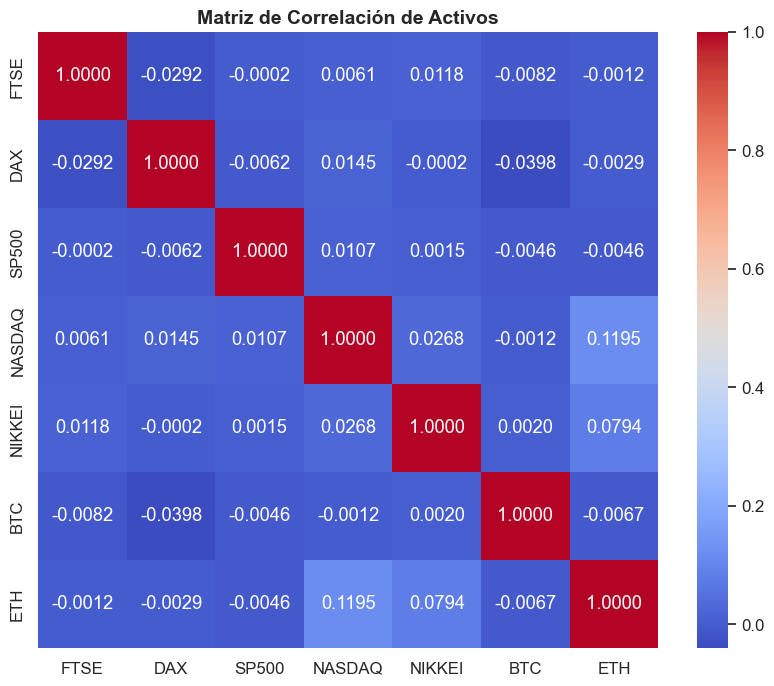

In [61]:
    #! Funcionan con rendimientos
# Matriz de correlacion
graficar_matriz_correlacion(data_w_cripto)

###### Grafica Pastel

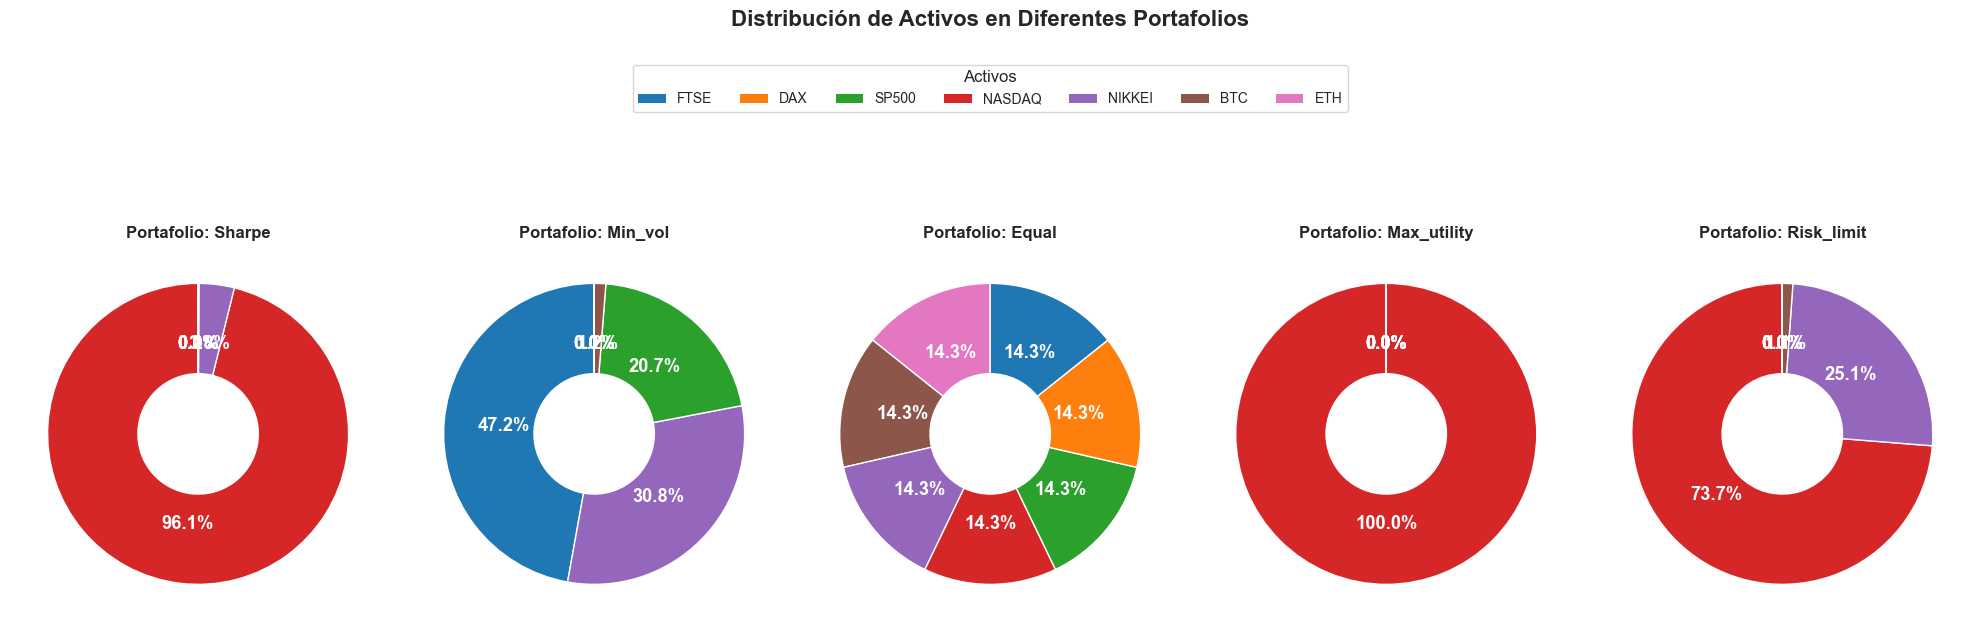

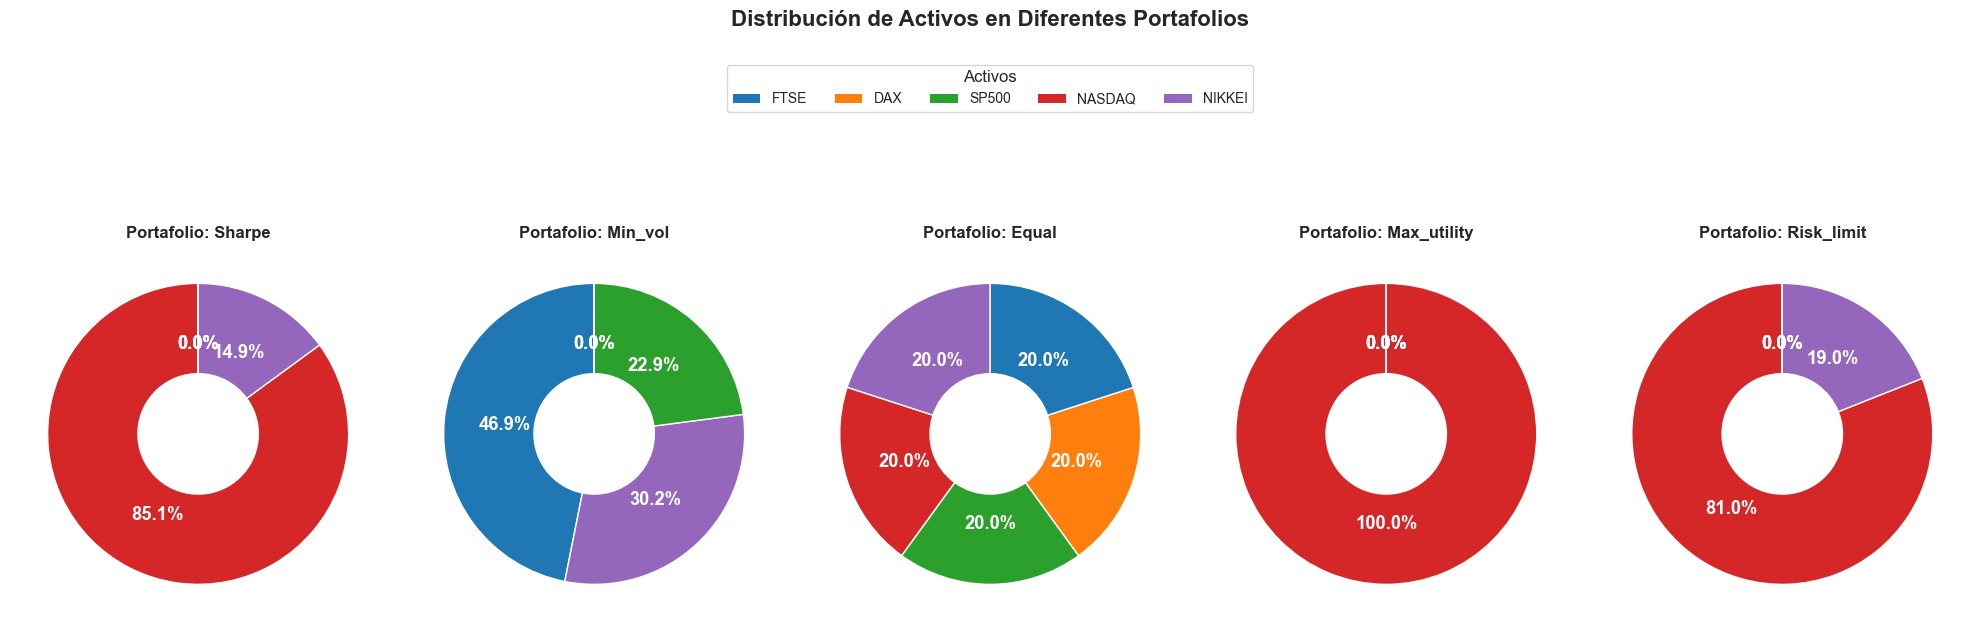

In [58]:
plot_portfolio_pies(data_w_cripto, risk_limit=risk_limit, min_weight=min_weight)
plot_portfolio_pies(data, risk_limit=risk_limit, min_weight=min_weight)

###### Frontera eficiente

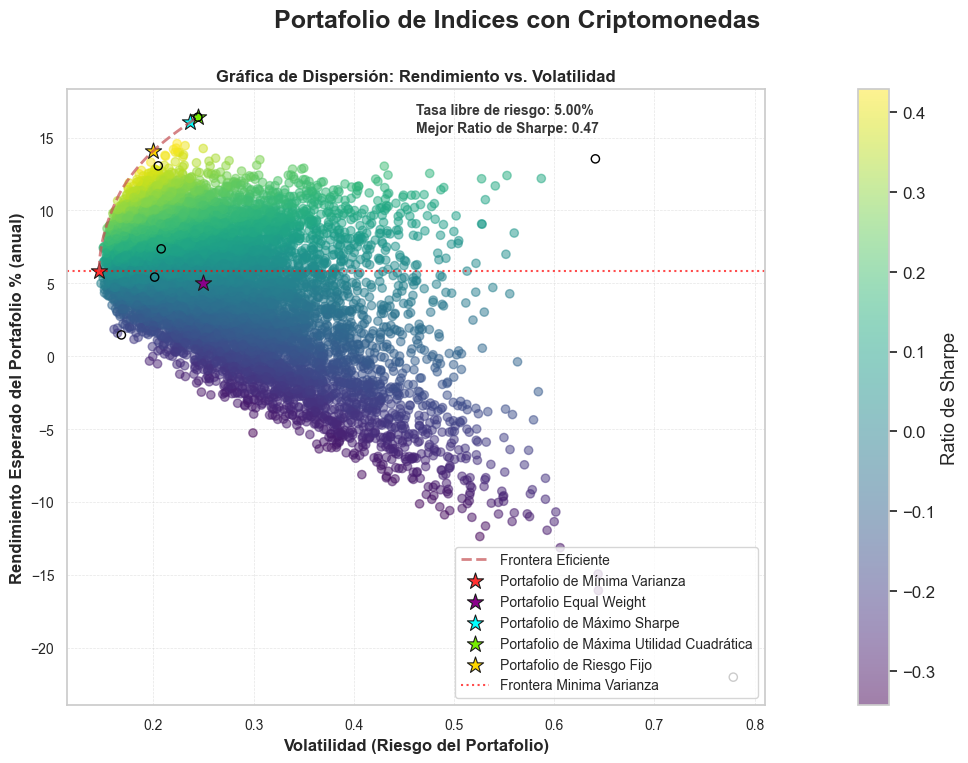

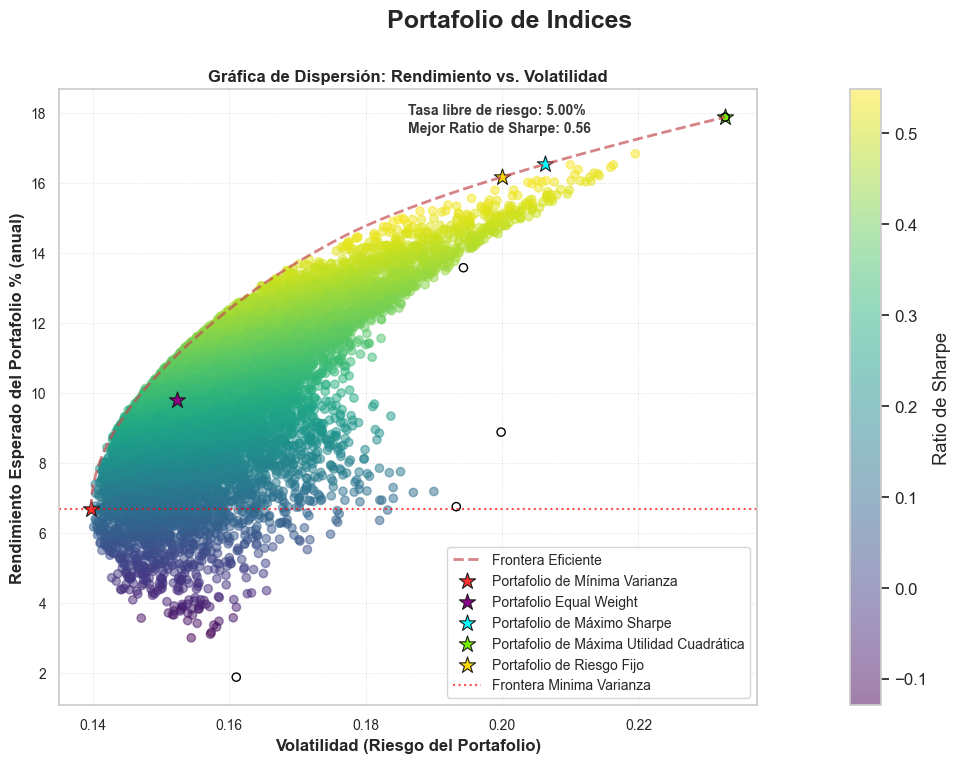

In [66]:
    #! Fuanciona con Rendimientos
graficar_frontera_eficiente(data_w_cripto, risk_free=risk_free, risk_limit=risk_limit, min_weight=min_weight, title='Portafolio de Indices con Criptomonedas')
graficar_frontera_eficiente(data, risk_free=risk_free, risk_limit=risk_limit, min_weight=min_weight, title='Portafolio de Indices')

###### Rendimientos acumulados

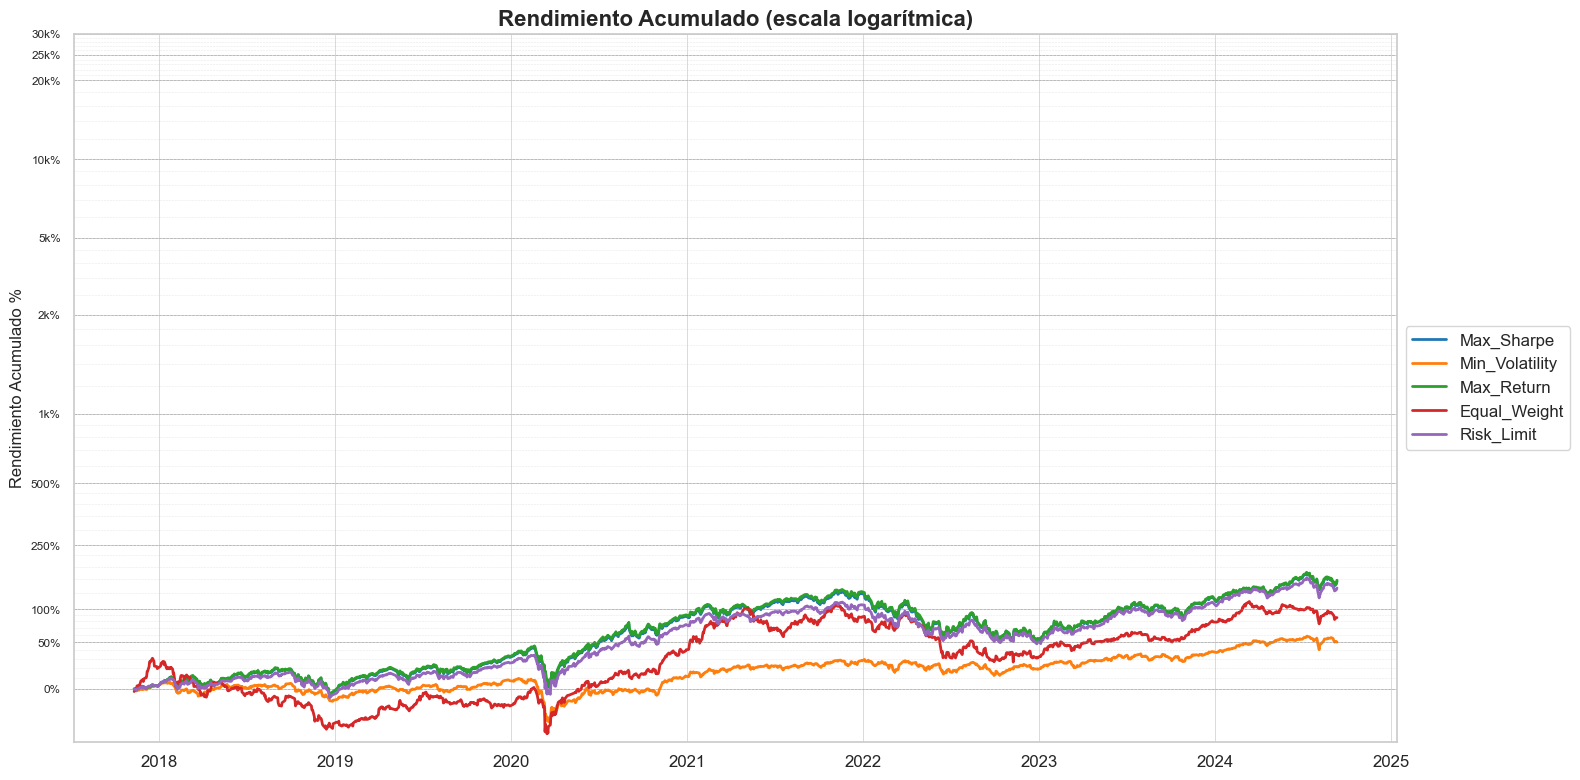

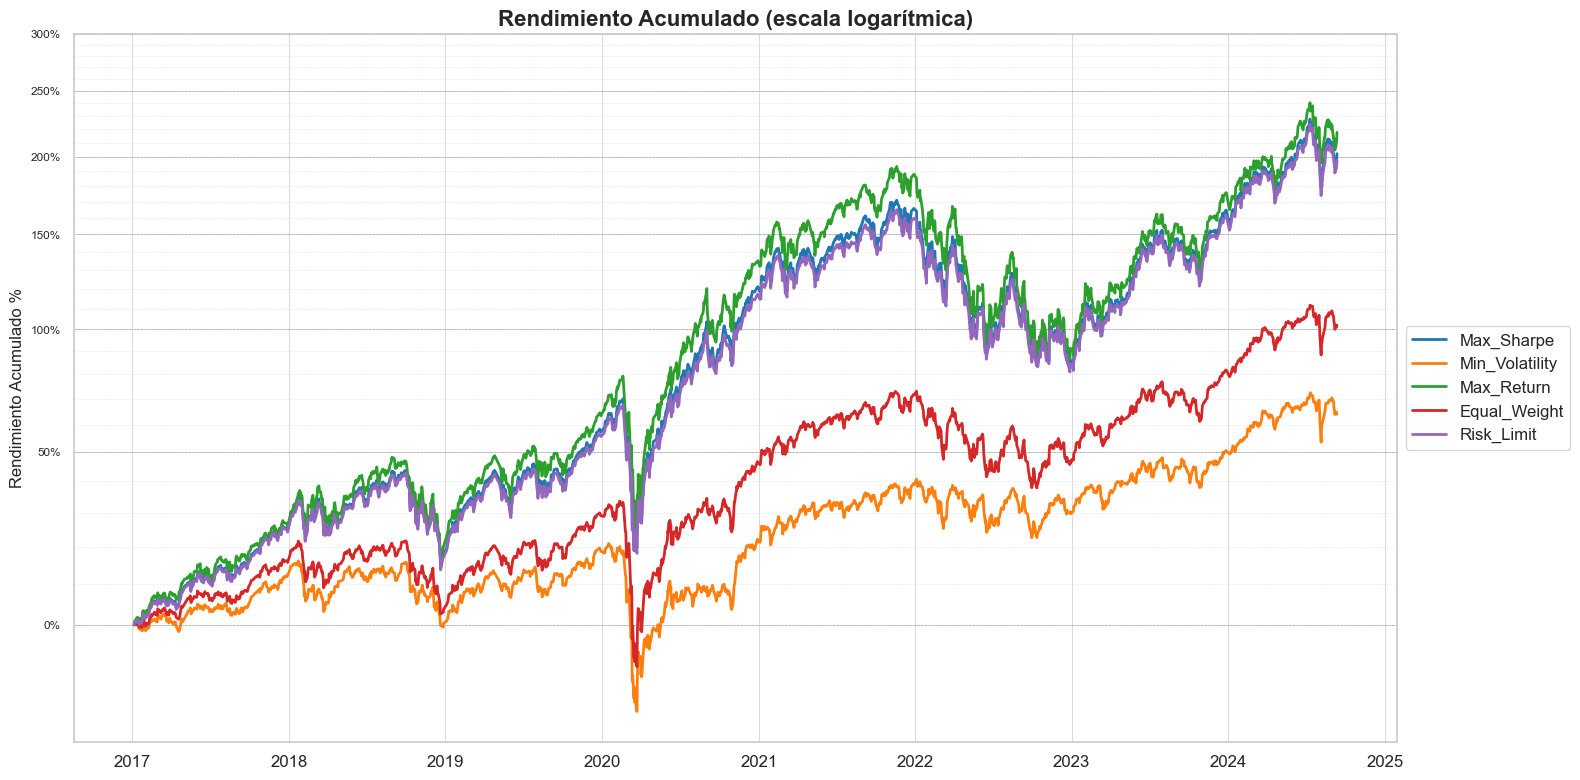

In [57]:
plot_cumulative_returns(data_w_cripto_port, yticks=[1,1.5, 2, 3.5, 6, 11, 26, 51, 101, 201, 251, 301], num_minor_ticks=4)
plot_cumulative_returns(data_port, yticks=[1,1.5, 2, 2.5, 3, 3.5, 4], num_minor_ticks=4)

##### Markov analisis

In [150]:
    #! Funcionan con rendimientos
test = markov_regresion(data, column=column, order=1, trend='n')
data_lvar = test['l_var']
data_hvar = test['h_var']

In [ ]:
    #! Funcionan con rendimientos
data_lvar_port = generate_portfolio_df(data_lvar,
                        include_sharpe=True, 
                        include_min_vol=False, 
                        include_max_return=False,
                        include_equal_weight=False, 
                        include_risk_limit=False, 
                        risk_free=risk_free, 
                        risk_limit=risk_limit,
                        min_weight=min_weight,
                        include_assets=False,
                        save_weights=False,
                        use_returns=True)
data_lvar_w_cripto = add_cripto(data_lvar, cripto.pct_change().dropna(), ['BTC', 'ETH'])
data_lvar_w_cripto_port = generate_portfolio_df(data_lvar_w_cripto,
                        include_sharpe=True, 
                        include_min_vol=False, 
                        include_max_return=False,
                        include_equal_weight=False, 
                        include_risk_limit=False, 
                        risk_free=risk_free, 
                        risk_limit=risk_limit,
                        min_weight=min_weight,
                        include_assets=False,
                        save_weights=False,
                        use_returns=True)

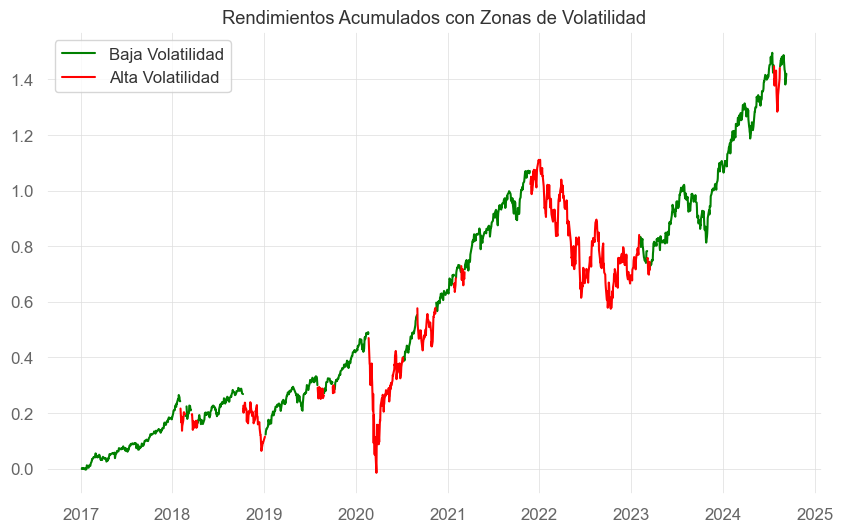

In [151]:
    #! Funcionan con rendimientos
markov_cumrends_plot_line(data, column=column, order=1, trend='n')

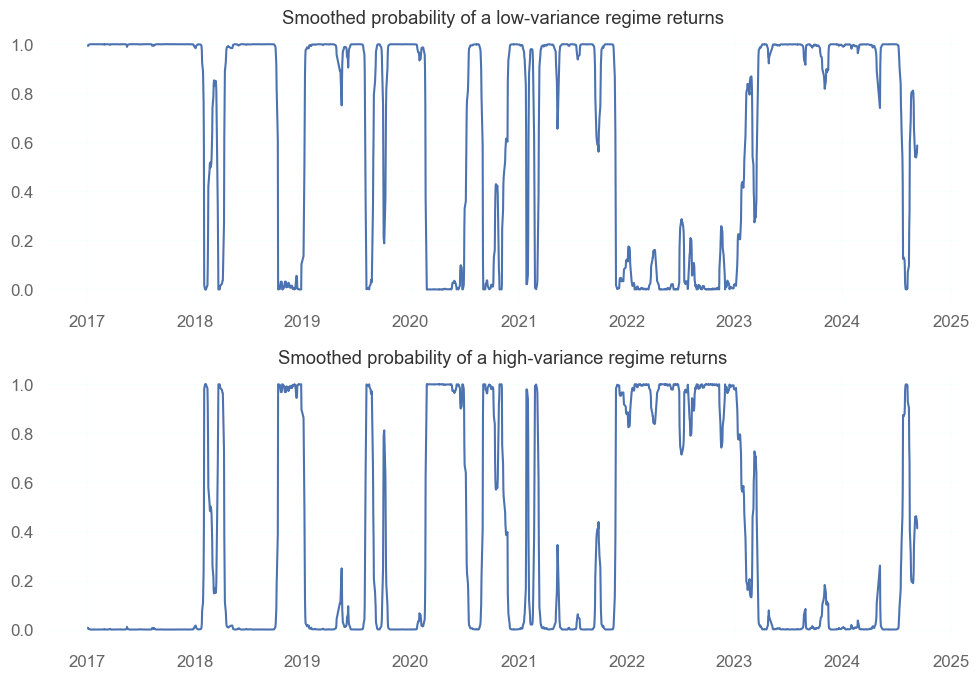

In [152]:
    #! Funcionan con rendimientos
markov_prob_plot(data,column=column, order=1, trend='n')